In [1]:
from google.colab import drive
drive.mount('/content/drive')

wd = "/content/drive/MyDrive/manifold"

import os
# fixer le repertoire de travail
os.chdir(wd)
# Forcer UTF-8
os.environ['LC_ALL'] = 'C.UTF-8'
os.environ['LANG'] = 'C.UTF-8'

import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Installation optuna ( racalcitrante par pip)
import subprocess
subprocess.run(['pip', 'install', 'optuna'])


# Lister les GPU disponibles et leurs carctéristiques
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs disponibles : {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("Aucun GPU disponible.")

for gpu in gpus:
    details = tf.config.experimental.get_device_details(gpu)
    print(details)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs disponibles : 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
{'compute_capability': (8, 0), 'device_name': 'NVIDIA A100-SXM4-40GB'}


## configuration de l'environnement:

In [2]:
# Bibilothèque "rapids" pour accélérer le calcul matriciel
!pip install\
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
    cugraph-cu12==24.10.* cuspatial-cu12==24.10.* cuproj-cu12==24.10.* \
    cuxfilter-cu12==24.10.* cucim-cu12==24.10.* pylibraft-cu12==24.10.* \
    raft-dask-cu12==24.10.* cuvs-cu12==24.10.* nx-cugraph-cu12==24.10.*


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 100.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install scikit-dimension


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.0 MB/s eta 0:00:00


In [4]:
# Pour rercréer l'environnement avec les bonnes librairies compatibles ( dans ce cas, quelques difficultés à cause de la A100)
!pip freeze > requirements.txt

In [5]:
# Boite à outils ( import librairies et aide aux affichages etc)
import cupy as cp
import cuml
from cuml.decomposition import PCA
import pandas as pd
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
import tensorflow as tf
from tensorflow.keras import layers, models, Model

random.seed(0)



def afficher_donnees_3d(X, axes_permutation=1, titre="Visualisation 3D", cmap='coolwarm', elev=45, azim=45, figsize=(10, 8)):
    """
    Affiche les trois premières colonnes d'un ensemble de données en 3D avec permutation des axes.
    Le paramètre 'axes_permutation' prend les valeurs suivantes :
    1 - (X, Y, Z)
    2 - (X, Z, Y)
    3 - (Y, Z, X)
    """
    if X.shape[1] < 3:
        raise ValueError("X doit avoir au moins 3 colonnes")

    # Permuter les axes selon la valeur de axes_permutation
    if axes_permutation == 1:
        x, y, z = X[:, 0], X[:, 1], X[:, 2]  # (X, Y, Z)
        xlabel, ylabel, zlabel = "X", "Y", "Z"
        c = y  # Couleur en fonction de Y pour mettre en évidence l'ondulation sur Y
    elif axes_permutation == 2:
        x, y, z = X[:, 0], X[:, 2], X[:, 1]  # (X, Z, Y)
        xlabel, ylabel, zlabel = "X", "Z", "Y"
        c = z  # Couleur en fonction de Z pour mettre en évidence l'ondulation sur Z
    elif axes_permutation == 3:
        x, y, z = X[:, 1], X[:, 2], X[:, 0]  # (Y, Z, X)
        xlabel, ylabel, zlabel = "Y", "Z", "X"
        c = x  # Couleur en fonction de X pour mettre en évidence l'ondulation sur X
    else:
        raise ValueError("axes_permutation doit être 1, 2 ou 3")

    # Création de la figure 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Création du scatter plot
    scatter = ax.scatter(x, y, z, c=c, cmap=cmap)

    # Ajout des titres et étiquettes des axes
    ax.set_title(titre)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)

    # Ajustement de l'angle de vue
    ax.view_init(elev=elev, azim=azim)

    # Affichage
    plt.show()

## 1.  Génération synthétique de manifolds à visée académique

### 1.1 Manifold 1d en simple hélice

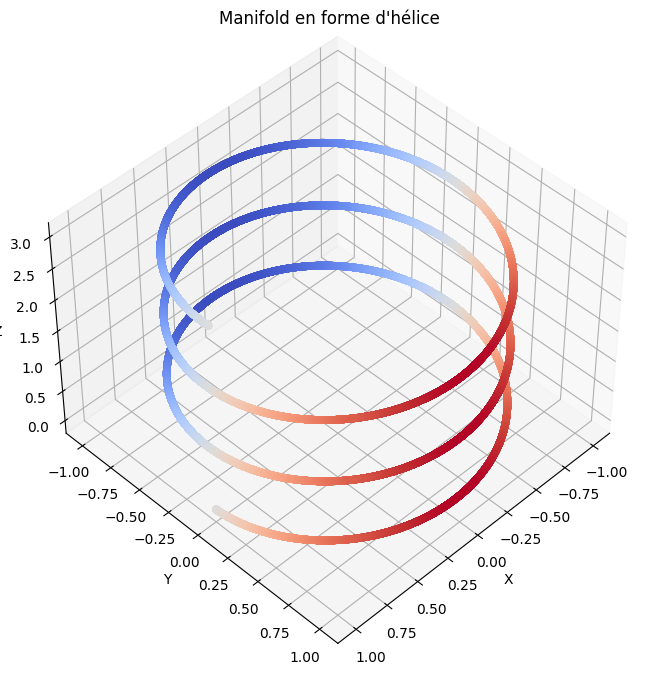

In [6]:
def generer_helice(n_points=100000, n_dims=100, bruit=0.0, nombre_tours=3):
    """
    Génère un manifold en forme d'hélice sans ondulation.

    :param n_points: Nombre de points à générer (défaut: 100000)
    :param n_dims: Nombre total de dimensions du dataset (défaut: 100, doit être >= 3)
    :param bruit: Amplitude du bruit gaussien (défaut: 0.0)
    :param nombre_tours: Nombre de tours que fait l'hélice
    :return: Un array numpy de shape (n_points, n_dims) représentant les coordonnées du dataset
    """
    if n_dims < 3:
        raise ValueError("Le nombre de dimensions doit être au moins 3")

    # Paramètre t pour contrôler l'évolution de l'hélice
    t = cp.linspace(0, nombre_tours * 2 * cp.pi, n_points)

    # Coordonnées x, y, z pour former l'hélice
    x = cp.cos(t)
    y = cp.sin(t)
    z = cp.linspace(0, nombre_tours, n_points)  # Le long de l'axe z pour former l'hélice

    # Création de l'hélice de base
    X = cp.column_stack((x, y, z))

    # Ajout du bruit aux 3 premières dimensions
    if bruit > 0:
        X[:, :3] += bruit * cp.random.randn(n_points, 3)

    # Ajout des dimensions supplémentaires avec des données aléatoires
    if n_dims > 3:
        X_extra = cp.random.randn(n_points, n_dims - 3)/ n_points
        X = cp.hstack((X, X_extra))

    # Conversion du résultat en array NumPy pour la compatibilité avec Matplotlib
    return cp.asnumpy(X)


X_helice = generer_helice()
afficher_donnees_3d(X_helice, titre="Manifold en forme d'hélice")

### 1.2 Deux manifolds 1d enroulés, les brins d'ADN

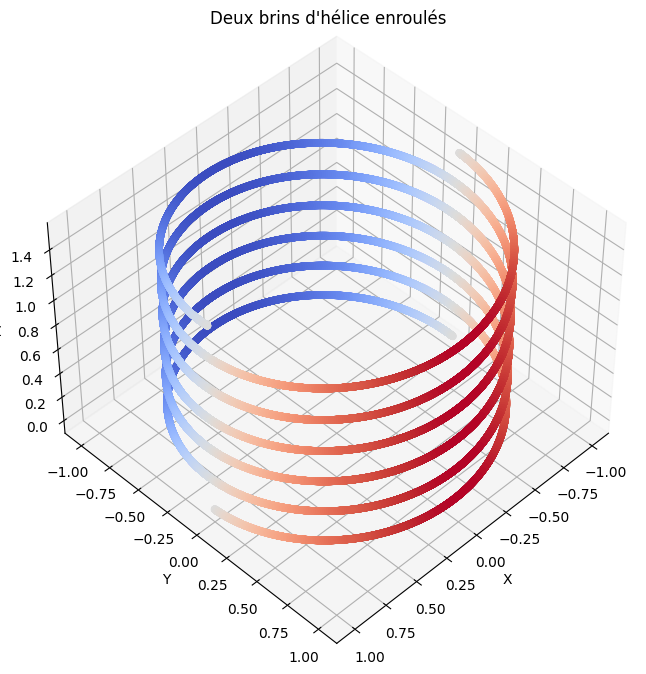

In [7]:
def generer_adn_double_helice(n_points=100000, n_dims=100, bruit=0.0, nombre_tours=3, rayon=1, pas=0.5):
    """
    Génère un manifold en forme de double hélice ADN avec segments de liaison.
    :param n_points: Nombre de points à générer (défaut: 100000)
    :param n_dims: Nombre total de dimensions du dataset (défaut: 100, doit être >= 3)
    :param bruit: Amplitude du bruit gaussien (défaut: 0.0)
    :param nombre_tours: Nombre de tours que fait la double hélice (défaut: 10)
    :param rayon: Rayon de la double hélice (défaut: 1)
    :param pas: Pas de l'hélice (défaut: 1)
    :param nombre_segments: Nombre de segments de liaison entre les brins (défaut: 20)
    :return: Un array numpy de shape (n_points, n_dims) représentant les coordonnées du dataset
    """
    if n_dims < 3:
        raise ValueError("Le nombre de dimensions doit être au moins 3")

    # Paramètre t pour contrôler l'évolution de la double hélice
    t = cp.linspace(0, nombre_tours * 2 * cp.pi, n_points//2)

    # Création des deux brins d'ADN
    x1 = rayon * cp.cos(t)
    y1 = rayon * cp.sin(t)
    z1 = pas * t / (2 * cp.pi)

    x2 = rayon * cp.cos(t + cp.pi)
    y2 = rayon * cp.sin(t + cp.pi)
    z2 = z1


    # Combinaison des brins et des segments
    X = cp.vstack([
        cp.column_stack((x1, y1, z1)),
        cp.column_stack((x2, y2, z2))
    ])

    # Ajout du bruit aux 3 premières dimensions
    if bruit > 0:
        X[:, :3] += bruit * cp.random.randn(X.shape[0], 3)

    # Ajout des dimensions supplémentaires avec des données aléatoires
    if n_dims > 3:
        X_extra = cp.random.randn(X.shape[0], n_dims - 3)/ n_points
        X = cp.hstack((X, X_extra))

    # Conversion du résultat en array NumPy pour la compatibilité avec Matplotlib
    return cp.asnumpy(X)

# Exemple d'utilisation
X_adn = generer_adn_double_helice()

afficher_donnees_3d(X_adn, titre="Deux brins d'hélice enroulés")

### 1.3 Manifold 2d, Le Swiss Roll ondulé

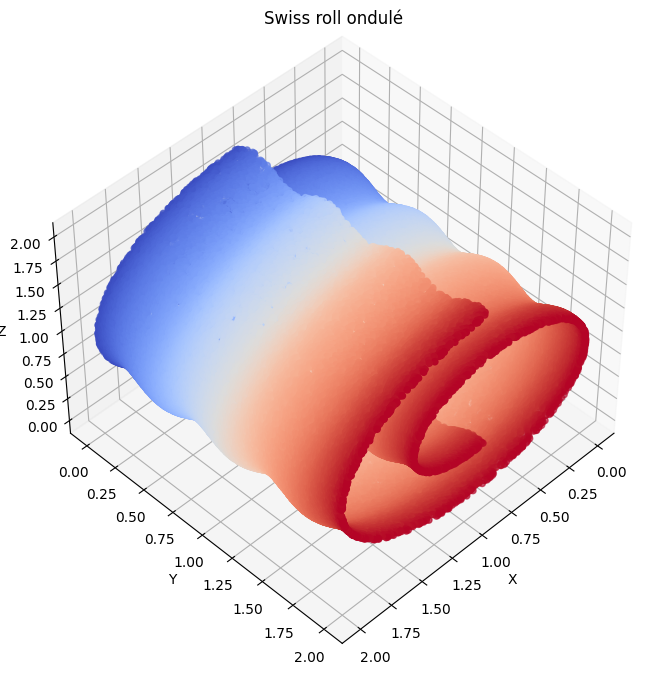

In [8]:
def generer_swiss_roll_ondule(n_points=100000, n_dims=100, bruit=0.0, amplitude_ondulation=1.0, frequence_ondulation=1.0):
    """
    Génère un Swiss roll avec une ondulation sinusoïdale selon l'axe z, et les trois premières dimensions
    étalonnées entre 0 et 2.

    :param n_points: Nombre de points à générer (défaut: 100000)
    :param n_dims: Nombre total de dimensions du dataset (défaut: 100, doit être >= 3)
    :param bruit: Amplitude du bruit gaussien (défaut: 0.0)
    :param amplitude_ondulation: Amplitude de l'ondulation sinusoïdale sur l'axe z (défaut: 1.0)
    :param frequence_ondulation: Fréquence de l'ondulation sinusoïdale sur l'axe z (défaut: 1.0)
    :return: Un array numpy de shape (n_points, n_dims) représentant les coordonnées du dataset
    """
    if n_dims < 3:
        raise ValueError("Le nombre de dimensions doit être au moins 3")

    # Paramètre t pour l'enroulement du Swiss roll
    t = 1.5 * cp.pi * (1 + 2 * cp.random.rand(n_points))  # Valeur de t pour l'enroulement
    x = t * cp.cos(t)  # Coordonnée x
    y = 21 * cp.random.rand(n_points)  # Hauteur aléatoire y
    z = t * cp.sin(t)  # Coordonnée z de base pour le Swiss roll

    # Ajout d'une ondulation sinusoïdale sur l'axe z
    z += amplitude_ondulation * cp.sin(frequence_ondulation * y)  # Ondulation sur z

    # Mise à l'échelle des trois premières dimensions pour être entre 0 et 2
    x = 2 * (x - cp.min(x)) / (cp.max(x) - cp.min(x))
    y = 2 * (y - cp.min(y)) / (cp.max(y) - cp.min(y))
    z = 2 * (z - cp.min(z)) / (cp.max(z) - cp.min(z))

    # Création du Swiss roll de base avec ondulation
    X = cp.column_stack((x, y, z))

    # Ajout du bruit aux 3 premières dimensions
    if bruit > 0:
        X[:, :3] += bruit * cp.random.randn(n_points, 3)

    # Ajout des dimensions supplémentaires avec des données aléatoires
    if n_dims > 3:
        X_extra = cp.random.randn(n_points, n_dims - 3)/ n_points
        X = cp.hstack((X, X_extra))

    # Conversion du résultat en array NumPy pour la compatibilité avec Matplotlib
    return cp.asnumpy(X)


X_swiss_roll = generer_swiss_roll_ondule()
afficher_donnees_3d(X_swiss_roll, titre="Swiss roll ondulé")

## 1.4 Un manifold 2d complexe, la parbloide hyperbolique ou motif en selle de cheval

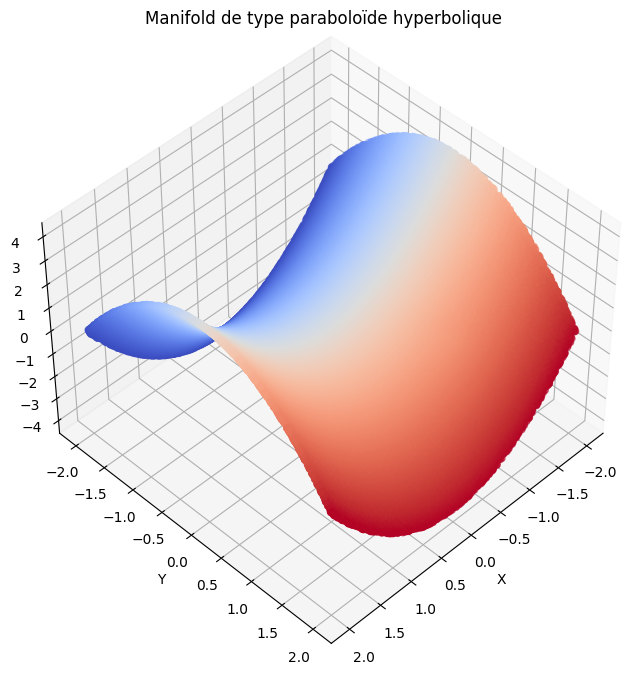

In [9]:
def generer_paraboloide_hyperbolique(n_points=100000, n_dims=100, bruit=0.0, etendue_x=2.0, etendue_y=2.0):
    """
    Génère un manifold de type paraboloïde hyperbolique.

    :param n_points: Nombre de points à générer (défaut: 10000)
    :param n_dims: Nombre total de dimensions du dataset (défaut: 100, doit être >= 3)
    :param bruit: Amplitude du bruit gaussien (défaut: 0.0)
    :param etendue_x: Amplitude des coordonnées x (défaut: 5.0)
    :param etendue_y: Amplitude des coordonnées y (défaut: 5.0)
    :return: Un array numpy de shape (n_points, n_dims) représentant les coordonnées du dataset
    """
    if n_dims < 3:
        raise ValueError("Le nombre de dimensions doit être au moins 3")

    # Générer des points aléatoires dans les dimensions x et y
    x = cp.random.uniform(-etendue_x, etendue_x, n_points)
    y = cp.random.uniform(-etendue_y, etendue_y, n_points)

    # Calculer z = x^2/a^2 - y^2/b^2 pour la paraboloïde hyperbolique
    z = (x**2) - (y**2)  # On peut choisir a = 1 et b = 1 pour simplifier

    # Création du manifold 3D avec x, y, z
    X = cp.column_stack((x, y, z))

    # Ajout du bruit aux 3 premières dimensions (x, y, z)
    if bruit > 0:
        X[:, :3] += bruit * cp.random.randn(n_points, 3)

    # Ajout des dimensions supplémentaires avec des données aléatoires si n_dims > 3
    if n_dims > 3:
        X_extra = cp.random.randn(n_points, n_dims - 3)/ n_points
        X = cp.hstack((X, X_extra))

    # Conversion en array cupy
    return cp.asnumpy(X)


X_paraboloide = generer_paraboloide_hyperbolique()
afficher_donnees_3d(X_paraboloide, titre="Manifold de type paraboloïde hyperbolique")

### 1.5 Disque incliné dans un hyper espace

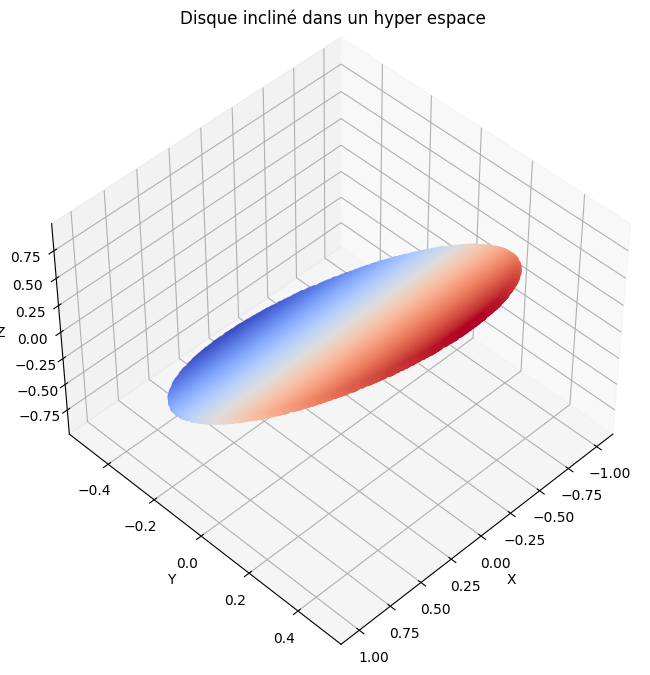

In [10]:
def generer_disque_incline(n_points=100000, n_dims=100, bruit=0.0, inclinaison=120):
    """
    Génère un disque incliné dans les trois premiers axes et ajoute des dimensions aléatoires dans les autres dimensions.

    :param n_points: Nombre de points à générer (défaut: 100000)
    :param n_dims: Nombre total de dimensions du dataset (défaut: 100, doit être >= 3)
    :param bruit: Amplitude du bruit gaussien ajouté aux trois premières dimensions (défaut: 0.0)
    :param inclinaison: Angle d'inclinaison du disque par rapport à l'axe Z en degrés (défaut: 45)
    :return: Un array numpy de shape (n_points, n_dims) représentant les coordonnées du dataset
    """
    if n_dims < 3:
        raise ValueError("Le nombre de dimensions doit être au moins 3")

    # Paramètre pour générer des coordonnées polaires (rayon et angle)
    angles = cp.linspace(0, 2 * cp.pi, n_points)
    rayon = cp.random.uniform(0, 1, n_points)

    # Générer les coordonnées du disque
    x = rayon * cp.cos(angles)
    y = rayon * cp.sin(angles)
    z = cp.zeros(n_points)  # Plan Z initial avant inclinaison

    # Appliquer une rotation/inclinaison autour de l'axe X pour incliner le disque
    theta = cp.radians(inclinaison)
    z_incline = z * cp.cos(theta) - y * cp.sin(theta)
    y_incline = z * cp.sin(theta) + y * cp.cos(theta)

    # Combiner pour créer un disque incliné dans (X, Y, Z)
    X_disque = cp.column_stack((x, y_incline, z_incline))

    # Ajouter du bruit aux 3 premières dimensions
    if bruit > 0:
        X_disque[:, :3] += bruit * cp.random.randn(n_points, 3)

    # Ajout des dimensions supplémentaires avec des données aléatoires
    if n_dims > 3:
        X_extra =  cp.random.randn(n_points, n_dims - 3) / n_points
        X_disque = cp.hstack((X_disque, X_extra))

    # Conversion du résultat en array NumPy pour la compatibilité avec Matplotlib
    return cp.asnumpy(X_disque)

# Exemple d'utilisation
X_disque = generer_disque_incline(n_points=100000, n_dims=100, bruit=0.00, inclinaison=120)
afficher_donnees_3d(X_disque, titre="Disque incliné dans un hyper espace")


#### Instances de datasets
Avant d'attaquer le protocole expérimentale, récupérons des exemplaires de chaque manifold avec et sans bruit

In [11]:
random.seed(0)
# Liste des datasets sans bruit
datasets_1 = [
    generer_helice(n_points=1000, bruit=0.0),
    generer_adn_double_helice(n_points=1000, bruit=0.0),
    generer_swiss_roll_ondule(n_points=1000, bruit=0.0),
    generer_paraboloide_hyperbolique(n_points=1000, bruit=0.0),
    generer_disque_incline(n_points=1000, bruit=0.0)
]


random.seed(0)
# Liste des datasets avec plus de bruit
datasets_2 = [
    generer_helice(n_points=1000, bruit=0.05),
    generer_adn_double_helice(n_points=1000, bruit=0.05),
    generer_swiss_roll_ondule(n_points=1000, bruit=0.05),
    generer_paraboloide_hyperbolique(n_points=1000, bruit=0.05),
    generer_disque_incline(n_points=1000, bruit=0.05)
]


In [12]:
## 2. Méthode de Calibrage : librairie optuna

**Introduction**

Dans le cadre de notre étude comparative des méthodes de réduction de dimension, le calibrage des hyperparamètres joue un rôle crucial pour optimiser les performances de chaque algorithme. Nous avons choisi d'utiliser Optuna, un framework d'optimisation automatique des hyperparamètres, plutôt qu'une validation croisée classique. Cette section explique les raisons de ce choix et présente le fonctionnement d'Optuna ainsi que ses fondements techniques et mathématiques.


### 2.1 **Pourquoi Optuna ?**

- Limitations de la validation croisée classique

La validation croisée classique, bien que largement utilisée, présente certaines limitations :

Exploration exhaustive : Elle nécessite souvent une recherche par grille ou aléatoire, ce qui peut être inefficace pour des espaces de paramètres complexes.
Temps de calcul : Pour des modèles complexes ou de grands jeux de données, le temps de calcul peut devenir prohibitif.


Difficulté à gérer les dépendances : Les interactions entre hyperparamètres sont difficiles à capturer.

- Avantages d'Optuna

Optuna offre plusieurs avantages qui en font une solution plus adaptée à notre étude :

Optimisation guidée : Utilise des algorithmes d'optimisation bayésienne pour explorer efficacement l'espace des hyperparamètres.


Flexibilité : Permet de définir des espaces de recherche complexes et des contraintes sur les hyperparamètres.


Parallélisation : Supporte nativement l'exécution parallèle des essais, réduisant le temps total d'optimisation.


Pruning : Arrête automatiquement les essais non prometteurs, économisant des ressources de calcul.


Visualisation : Offre des outils de visualisation intégrés pour analyser les résultats de l'optimisation.



### 2.2 **Fonctionnement d'Optuna**

#### 2.2.1 Principe de base

Optuna fonctionne sur le principe de l'optimisation séquentielle basée sur des modèles (SMBO - Sequential Model-Based Optimization). Voici les étapes clés :


Définition de l'espace de recherche : L'utilisateur définit les hyperparamètres à optimiser et leurs plages de valeurs.


Suggestion de paramètres : Optuna suggère un ensemble d'hyperparamètres à tester.


Évaluation : Le modèle est entraîné et évalué avec ces hyperparamètres.


Mise à jour du modèle : Optuna met à jour son modèle interne avec les résultats.
Itération : Les étapes 2-4 sont répétées jusqu'à atteindre un critère d'arrêt.

#### 2.2.2 Algorithmes d'optimisation

Optuna utilise principalement deux types d'algorithmes :

- Tree-structured Parzen Estimator (TPE) : Un algorithme bayésien qui modélise la distribution des hyperparamètres en fonction de leurs performances.


- Optimisation multi-objectifs : Permet d'optimiser plusieurs métriques simultanément, utilisant des concepts comme le front de Pareto.

#### 2.2.3 Fondements mathématiques

- Tree-structured Parzen Estimator (TPE)

Le TPE est basé sur l'estimation de densité par noyau (KDE - Kernel Density Estimation). Il modélise deux distributions :

$l(x)$ : Distribution des hyperparamètres donnant de bons résultats.

$g(x)$ : Distribution des hyperparamètres donnant de mauvais résultats.

L'algorithme cherche à maximiser le ratio $l(x)/g(x)$, ce qui équivaut à maximiser la probabilité d'amélioration.


- La fonction d'acquisition utilisée est l'amélioration attendue (EI - Expected Improvement) :

$EI(x) = \int_{-\infty}^{\gamma} (\gamma - y) p(y|x) dy$

où $\gamma$ est un seuil de performance et $p(y|x)$ est la probabilité de la performance $y$ étant donné les hyperparamètres $x$.

#### 2.2.4 Pruning adaptatif

Optuna utilise des algorithmes de pruning comme Hyperband ou Asynchronous Successive Halving (ASHA) pour arrêter précocement les essais non prometteurs.

Ces algorithmes sont basés sur des principes de bandit multi-bras et d'allocation dynamique des ressources.

### Conclusion

Le choix d'Optuna pour notre étude comparative se justifie par sa capacité à explorer efficacement des espaces d'hyperparamètres complexes, sa flexibilité, et son efficacité computationnelle. Ses fondements mathématiques solides, combinant optimisation bayésienne et techniques avancées de pruning, en font un outil particulièrement adapté à notre tâche de calibrage des hyperparamètres pour les méthodes de réduction de dimension.

## 3. Méthodes de réduction de dimensionalité et calibrage sur les datasets synthétiques

### 3.1 PCA



La PCA est une technique de réduction de dimensionnalité qui vise à transformer un espace de grande dimension en un espace de plus faible dimension, tout en préservant le maximum de variance dans les données.

### Principe de base

1. **Centrage des données** : Soustraire la moyenne de chaque caractéristique.
2. **Calcul de la matrice de covariance** : $\Sigma = \frac{1}{n-1} \mathbf{X}_{\text{centré}}^T \mathbf{X}_{\text{centré}}$
3. **Décomposition en valeurs propres** : $\Sigma \mathbf{v}_i = \lambda_i \mathbf{v}_i$
4. **Projection des données** : $\mathbf{X}_{\text{proj}} = \mathbf{X}_{\text{centré}} \mathbf{V}_k$

### Interprétation

- Les composantes principales sont ordonnées par variance décroissante.
- La variance expliquée par la $k$-ième composante : $\frac{\lambda_k}{\sum_{i=1}^{d} \lambda_i}$

avec  ${\lambda_k}$ la  $k$-ième valeur propre

### Applications

1. Réduction de dimensionnalité pour l'apprentissage automatique
2. Compression de données
3. Détection d'anomalies

Cette technique permet de simplifier les données tout en conservant leurs caractéristiques essentielles, facilitant ainsi l'analyse et la visualisation.


### Calibrage

In [13]:
import optuna
import cupy as cp
import pandas as pd
from cuml.decomposition import PCA as cuPCA

# Fonction d'objectif pour Optuna
def objective(trial, dataset):
    # Intervalle du nombre de composantes principales
    n_components = trial.suggest_int('n_components', 2, 10)

    # Utiliser cuML PCA sur GPU
    pca = cuPCA(n_components=n_components)
    X_pca = pca.fit_transform(cp.asarray(dataset))

    # Calculer la variance expliquée
    variance_expliquee = cp.asnumpy(pca.explained_variance_ratio_)

    # Obtenir la variance totale expliquée
    variance_totale = np.sum(variance_expliquee)

    # Une pénalité d'éloignement de l'espace euclidien
    penalty = abs(n_components - 3) * 0.1

    return variance_totale - penalty

# Listes pour stocker les meilleurs résultats
best_params_1 = []
best_params_2 = []

# Optimisation sur datasets_1 (sans bruit)
for dataset in datasets_1:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_1.append(study.best_params['n_components'])  # Stocker uniquement le meilleur n_components

# Optimisation sur datasets_2 (avec bruit)
for dataset in datasets_2:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_2.append(study.best_params['n_components'])  # Stocker uniquement le meilleur n_components

# Créer un DataFrame récapitulatif
datasets_names = [f'Dataset {i+1}' for i in range(len(datasets_1))]  # Nommer les datasets
df = pd.DataFrame({
    'Sans Bruit': best_params_1,
    'Avec Bruit': best_params_2
}, index=datasets_names)

# Afficher le DataFrame
display(df)


[I 2024-10-17 04:58:45,529] A new study created in memory with name: no-name-43ba3189-e3c0-46b9-8715-3ec2a8b619c0
[I 2024-10-17 04:58:46,243] Trial 0 finished with value: 0.5999486447972457 and parameters: {'n_components': 7}. Best is trial 0 with value: 0.5999486447972457.
[I 2024-10-17 04:58:46,254] Trial 1 finished with value: 0.9999449409359038 and parameters: {'n_components': 3}. Best is trial 1 with value: 0.9999449409359038.
[I 2024-10-17 04:58:46,263] Trial 2 finished with value: 0.2999512820999013 and parameters: {'n_components': 10}. Best is trial 1 with value: 0.9999449409359038.
[I 2024-10-17 04:58:46,272] Trial 3 finished with value: 0.5999486447972457 and parameters: {'n_components': 7}. Best is trial 1 with value: 0.9999449409359038.
[I 2024-10-17 04:58:46,280] Trial 4 finished with value: 0.8999458865365946 and parameters: {'n_components': 4}. Best is trial 1 with value: 0.9999449409359038.
[I 2024-10-17 04:58:46,288] Trial 5 finished with value: 0.6586591748433769 and 

Sans Bruit  Avec Bruit
Dataset 1           3           3
Dataset 2           3           3
Dataset 3           3           3
Dataset 4           3           3
Dataset 5           3           3

In [14]:
# Nombre de composantes principales à conserver
n_components = 3
# Listes pour stocker les résultats
PCA_datasets_1 = []
PCA_datasets_2 = []

# Boucle sur datasets_1 (sans bruit)
for dataset in datasets_1:
    # Instancier l'objet PCA
    pca = PCA(n_components=n_components)

    # Appliquer la PCA et récupérer les données projetées
    X_pca = pca.fit_transform(dataset)

    # Récupérer la variance expliquée par chaque composante
    variance_expliquee = pca.explained_variance_ratio_

    # Stocker les résultats dans la liste PCA_datasets_1
    PCA_datasets_1.append((X_pca, variance_expliquee))

# Boucle sur datasets_2 (avec bruit)
for dataset in datasets_2:
    # Instancier l'objet PCA
    pca = PCA(n_components=n_components)

    # Appliquer la PCA et récupérer les données projetées
    X_pca = pca.fit_transform(dataset)

    # Récupérer la variance expliquée par chaque composante
    variance_expliquee = pca.explained_variance_ratio_

    # Stocker les résultats dans la liste PCA_datasets_2
    PCA_datasets_2.append((X_pca, variance_expliquee))

# Affichage des résultats pour datasets_1 (sans bruit)
print("Résultats PCA pour datasets_1 (sans bruit) :")
for i, (X_pca, variance_expliquee) in enumerate(PCA_datasets_1):
    print(f"Dataset {i+1} :")
    print(f"  Variance expliquée : {variance_expliquee}\n")

# Affichage des résultats pour datasets_2 (avec bruit)
print("Résultats PCA pour datasets_2 (avec bruit) :")
for i, (X_pca, variance_expliquee) in enumerate(PCA_datasets_2):
    print(f"Dataset {i+1} :")
    print(f"  Variance expliquée : {variance_expliquee}\n")


Résultats PCA pour datasets_1 (sans bruit) :
Dataset 1 :
  Variance expliquée : [0.47292046 0.28573871 0.24128577]

Dataset 2 :
  Variance expliquée : [0.42159367 0.41991064 0.1584145 ]

Dataset 3 :
  Variance expliquée : [0.37357949 0.34766683 0.27865162]

Dataset 4 :
  Variance expliquée : [0.52071297 0.24386372 0.23540585]

Dataset 5 :
  Variance expliquée : [5.04056178e-01 4.95649985e-01 5.12110876e-06]

Résultats PCA pour datasets_2 (avec bruit) :
Dataset 1 :
  Variance expliquée : [0.47147256 0.28564375 0.24282876]

Dataset 2 :
  Variance expliquée : [0.42226915 0.41753231 0.16011703]

Dataset 3 :
  Variance expliquée : [0.39950542 0.3345071  0.26588752]

Dataset 4 :
  Variance expliquée : [0.51684717 0.25235232 0.2307832 ]

Dataset 5 :
  Variance expliquée : [0.51715779 0.47572728 0.00683906]



<ipython-input-15-fe61df64ad02>:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 0].scatter(X_pca_1[:, 0], X_pca_1[:, 1], cmap='coolwarm')
<ipython-input-15-fe61df64ad02>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 1].scatter(X_pca_2[:, 0], X_pca_2[:, 1], cmap='coolwarm')


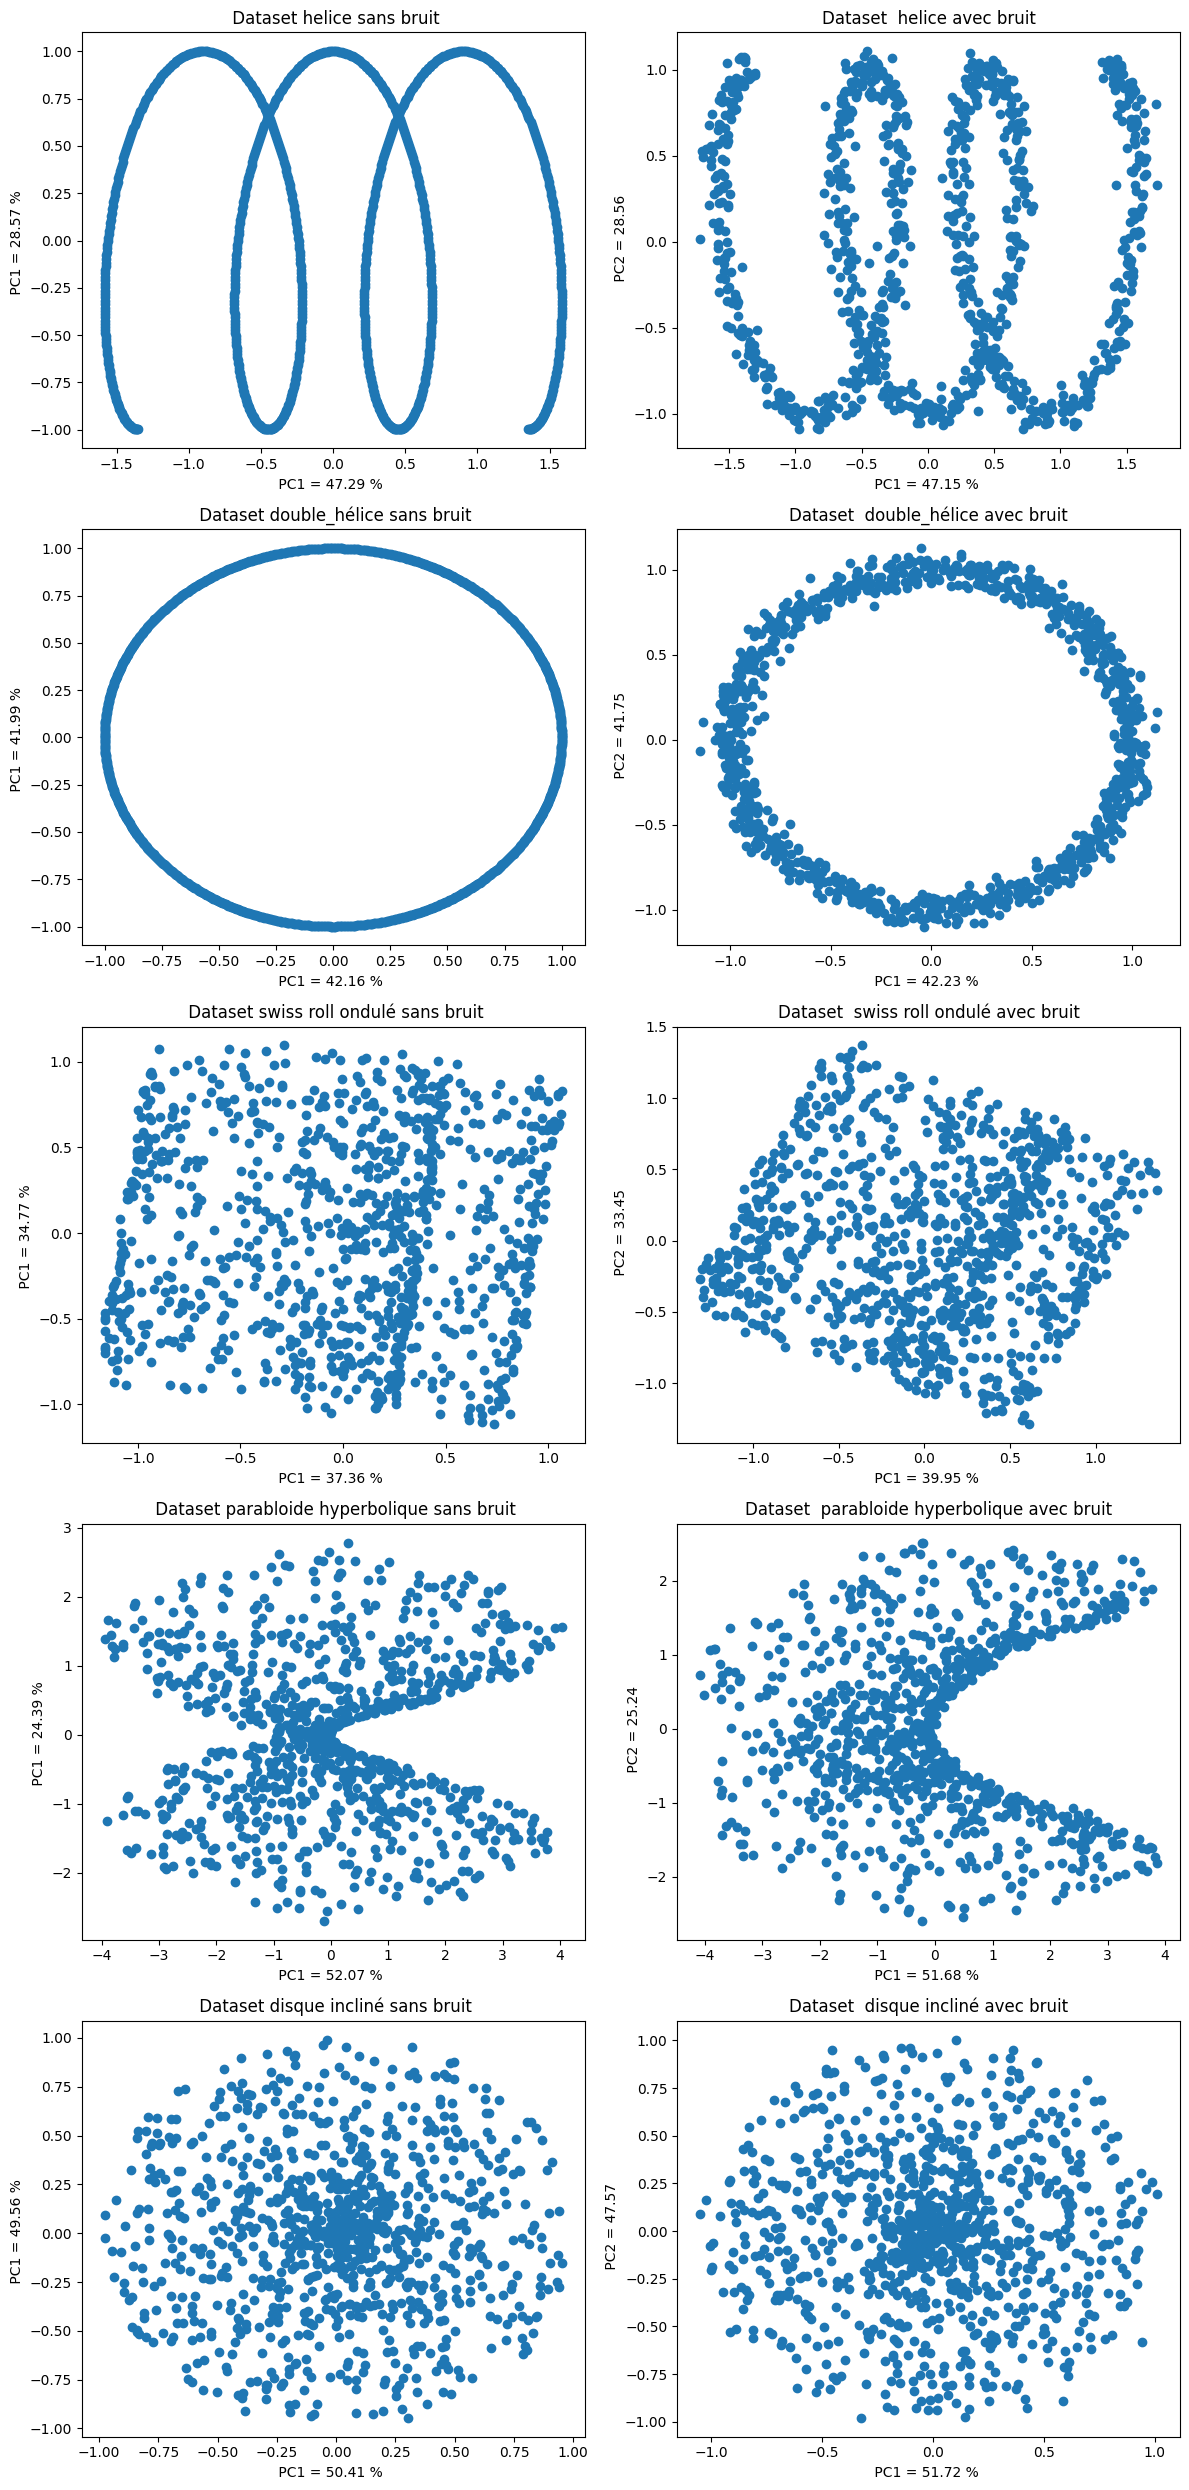

In [15]:
n_datasets = len(PCA_datasets_1)
# Création de la figure avec des subplots pour chaque dataset
fig, axes = plt.subplots(n_datasets, 2, figsize=(12, 5 * n_datasets))

noms=["helice","double_hélice","swiss roll ondulé", "parabloide hyperbolique", "disque incliné"]

# Boucle pour tracer chaque dataset
for i in range(n_datasets):
    # Dataset sans bruit (PCA_datasets_1)
    X_pca_1 = PCA_datasets_1[i][0]
    variance_expliquee_1 = PCA_datasets_1[i][1]
    axes[i, 0].scatter(X_pca_1[:, 0], X_pca_1[:, 1], cmap='coolwarm')
    axes[i, 0].set_title(f" Dataset {noms[i]} sans bruit")
    axes[i, 0].set_xlabel(f" PC1 = {variance_expliquee_1[0]* 100:.2f} %  ")
    axes[i, 0].set_ylabel(f" PC1 = {variance_expliquee_1[1]* 100:.2f} %  ")

    # Dataset avec bruit (PCA_datasets_2)
    X_pca_2 = PCA_datasets_2[i][0]
    variance_expliquee_2 = PCA_datasets_2[i][1]
    axes[i, 1].scatter(X_pca_2[:, 0], X_pca_2[:, 1], cmap='coolwarm')
    axes[i, 1].set_title(f"Dataset  {noms[i]} avec bruit")
    axes[i, 1].set_xlabel(f" PC1 = {variance_expliquee_2[0]* 100:.2f} %  ")
    axes[i, 1].set_ylabel(f" PC2 = {variance_expliquee_2[1]* 100:.2f}")

# Ajuster les espaces entre les subplots
plt.tight_layout()
plt.show()

### 3.2 ISOMAP (Isometric Mapping)

L'**Isomap** est une technique de réduction de la dimensionnalité non linéaire basée sur l'algorithme de multidimensional scaling (MDS). Contrairement à la PCA, l'Isomap préserve les distances géodésiques, mesurées le long de la surface du manifold, même si cette surface est non linéaire.

### Fondements Mathématiques

L'Isomap fonctionne en trois étapes principales :

1. **Construction du graphe des plus proches voisins**

   $G = (V, E)$ où $V$ est l'ensemble des points et $E$ les arêtes reliant les plus proches voisins

2. **Calcul des distances géodésiques**

   $d_{G}(i, j) = \text{la plus courte distance entre } i \text{ et } j \text{ sur le graphe}$

3. **Embedding des points dans un espace de dimension réduite**

   $\min \sum_{i, j} \left( d_{G}(i, j) - d_{\text{embedding}}(i, j) \right)^2$

### Comparaison avec la PCA

Contrairement à la PCA qui se limite à capturer les relations linéaires entre les données, l'Isomap est capable de réduire la dimensionnalité tout en capturant les structures non linéaires des données. Cela le rend particulièrement adapté à la réduction de dimension pour des données qui reposent sur des manifolds non linéaires, comme le **Swiss Roll** ou des formes complexes comme la selle de cheval.

### Calibrage

In [16]:
import optuna
import cupy as cp
import pandas as pd
from sklearn.manifold import Isomap

# Fonction d'objectif pour Optuna
def objective(trial, dataset):
    # Intervalle du nombre de composantes principales (dimensions réduites)
    n_components = trial.suggest_int('n_components', 2, 10)

    # Nombre de voisins à utiliser pour la construction du graphe
    n_neighbors = trial.suggest_int('n_neighbors', 4, 30)

    # Instancier l'objet Isomap avec les paramètres suggérés
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)

    # Appliquer Isomap et récupérer les données projetées
    X_isomap = isomap.fit_transform(dataset)

    # Calculer l'erreur de reconstruction d'Isomap
    erreur_reconstruction = isomap.reconstruction_error()

    # Minimiser l'erreur de reconstruction
    return erreur_reconstruction

# Listes pour stocker les meilleurs résultats
best_params_1 = []
best_params_2 = []

# calibrage sur datasets_1 (sans bruit)
for dataset in datasets_1:
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur de reconstruction
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_1.append({
        'n_components': study.best_params['n_components'],
        'n_neighbors': study.best_params['n_neighbors'],
        'reconstruction_error': study.best_value
    })

# calibrage sur datasets_2 (avec bruit)
for dataset in datasets_2:
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur de reconstruction
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_2.append({
        'n_components': study.best_params['n_components'],
        'n_neighbors': study.best_params['n_neighbors'],
        'reconstruction_error': study.best_value
    })

# Créer un DataFrame récapitulatif
datasets_names = [f'Dataset {i+1}' for i in range(len(datasets_1))]  # Nommer les datasets
df = pd.DataFrame({
    'Sans Bruit': best_params_1,
    'Avec Bruit': best_params_2
}, index=datasets_names)

# Afficher le DataFrame
display(df)


[I 2024-10-17 04:58:55,356] A new study created in memory with name: no-name-d80c8916-f2fa-414a-b0ba-205dcbd37d25
[I 2024-10-17 04:58:55,679] Trial 0 finished with value: 0.0004048462604193109 and parameters: {'n_components': 5, 'n_neighbors': 10}. Best is trial 0 with value: 0.0004048462604193109.
[I 2024-10-17 04:58:56,277] Trial 1 finished with value: 0.00044431018125900526 and parameters: {'n_components': 4, 'n_neighbors': 23}. Best is trial 0 with value: 0.0004048462604193109.
[I 2024-10-17 04:58:56,629] Trial 2 finished with value: 0.0003734979748141167 and parameters: {'n_components': 4, 'n_neighbors': 19}. Best is trial 2 with value: 0.0003734979748141167.
[I 2024-10-17 04:58:57,094] Trial 3 finished with value: 0.00033760367319992393 and parameters: {'n_components': 4, 'n_neighbors': 22}. Best is trial 3 with value: 0.00033760367319992393.
[I 2024-10-17 04:58:57,755] Trial 4 finished with value: 0.0011250418019475789 and parameters: {'n_components': 7, 'n_neighbors': 29}. Best

Sans Bruit  \
Dataset 1  {'n_components': 10, 'n_neighbors': 14, 'recon...   
Dataset 2  {'n_components': 10, 'n_neighbors': 30, 'recon...   
Dataset 3  {'n_components': 7, 'n_neighbors': 30, 'recons...   
Dataset 4  {'n_components': 10, 'n_neighbors': 29, 'recon...   
Dataset 5  {'n_components': 10, 'n_neighbors': 30, 'recon...   

                                                  Avec Bruit  
Dataset 1  {'n_components': 10, 'n_neighbors': 18, 'recon...  
Dataset 2  {'n_components': 10, 'n_neighbors': 30, 'recon...  
Dataset 3  {'n_components': 9, 'n_neighbors': 30, 'recons...  
Dataset 4  {'n_components': 10, 'n_neighbors': 29, 'recon...  
Dataset 5  {'n_components': 10, 'n_neighbors': 30, 'recon...

In [17]:
# Appliquer Isomap avec les hyperparamètres optimisés et stocker les résultats
Isomap_datasets_1 = []
Isomap_datasets_2 = []

# Appliquer Isomap sur datasets_1 (sans bruit)
for i, dataset in enumerate(datasets_1):
    # Utiliser les meilleurs hyperparamètres trouvés par Optuna
    n_components = best_params_1[i]['n_components']
    n_neighbors = best_params_1[i]['n_neighbors']

    # Instancier Isomap avec les hyperparamètres optimisés
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)

    # Appliquer Isomap et récupérer les données projetées
    X_isomap = isomap.fit_transform(dataset)

    # Calculer l'erreur de reconstruction
    erreur_reconstruction = isomap.reconstruction_error()

    # Stocker les résultats
    Isomap_datasets_1.append((X_isomap, erreur_reconstruction))

# Appliquer Isomap sur datasets_2 (avec bruit)
for i, dataset in enumerate(datasets_2):
    # Utiliser les meilleurs hyperparamètres trouvés par Optuna
    n_components = best_params_2[i]['n_components']
    n_neighbors = best_params_2[i]['n_neighbors']

    # Instancier Isomap avec les hyperparamètres optimisés
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)

    # Appliquer Isomap et récupérer les données projetées
    X_isomap = isomap.fit_transform(dataset)

    # Calculer l'erreur de reconstruction
    erreur_reconstruction = isomap.reconstruction_error()

    # Stocker les résultats
    Isomap_datasets_2.append((X_isomap, erreur_reconstruction))

# Affichage des résultats pour datasets_1 (sans bruit)
print("Résultats Isomap pour datasets_1 (sans bruit) :")
for i, (X_isomap, erreur_reconstruction) in enumerate(Isomap_datasets_1):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_isomap[:5]}\n")  # Afficher les 5 premières coordonnées

# Affichage des résultats pour datasets_2 (avec bruit)
print("Résultats Isomap pour datasets_2 (avec bruit) :")
for i, (X_isomap, erreur_reconstruction) in enumerate(Isomap_datasets_2):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_isomap[:5]}\n")  # Afficher les 5 premières coordonnées


Résultats Isomap pour datasets_1 (sans bruit) :
Dataset 1 :
  Erreur de reconstruction : 0.0002
  Coordonnées dans le nouvel espace :
 [[ 9.58410533e+00 -3.47847505e-02 -2.55878600e-02  2.34791128e-02
  -1.64350147e-03 -2.78918502e-03 -8.28954290e-03 -7.86517512e-03
  -1.17355545e-02 -5.39894599e-03]
 [ 9.56514903e+00 -3.48243139e-02 -2.55926687e-02  2.31873870e-02
  -1.73581099e-03 -2.65648290e-03 -8.44270195e-03 -7.61776684e-03
  -1.15791781e-02 -5.23096355e-03]
 [ 9.54611488e+00 -3.48174908e-02 -2.55557518e-02  2.30136677e-02
  -1.77209774e-03 -2.58457866e-03 -8.54444082e-03 -7.47737178e-03
  -1.15095474e-02 -5.14368970e-03]
 [ 9.52724718e+00 -3.47032768e-02 -2.54184088e-02  2.28983623e-02
  -1.72393212e-03 -2.62496461e-03 -8.34900392e-03 -7.52033013e-03
  -1.14436360e-02 -5.17145334e-03]
 [ 9.50819344e+00 -3.44620849e-02 -2.51782012e-02  2.28495476e-02
  -1.63684189e-03 -2.68721676e-03 -8.19584225e-03 -7.67007294e-03
  -1.15961908e-02 -5.35133115e-03]]

Dataset 2 :
  Erreur de reco

<ipython-input-18-f73ab9653b26>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 0].scatter(X_isomap_1[:, 0], X_isomap_1[:, 1], cmap='coolwarm')
<ipython-input-18-f73ab9653b26>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 1].scatter(X_isomap_2[:, 0], X_isomap_2[:, 1], cmap='coolwarm')


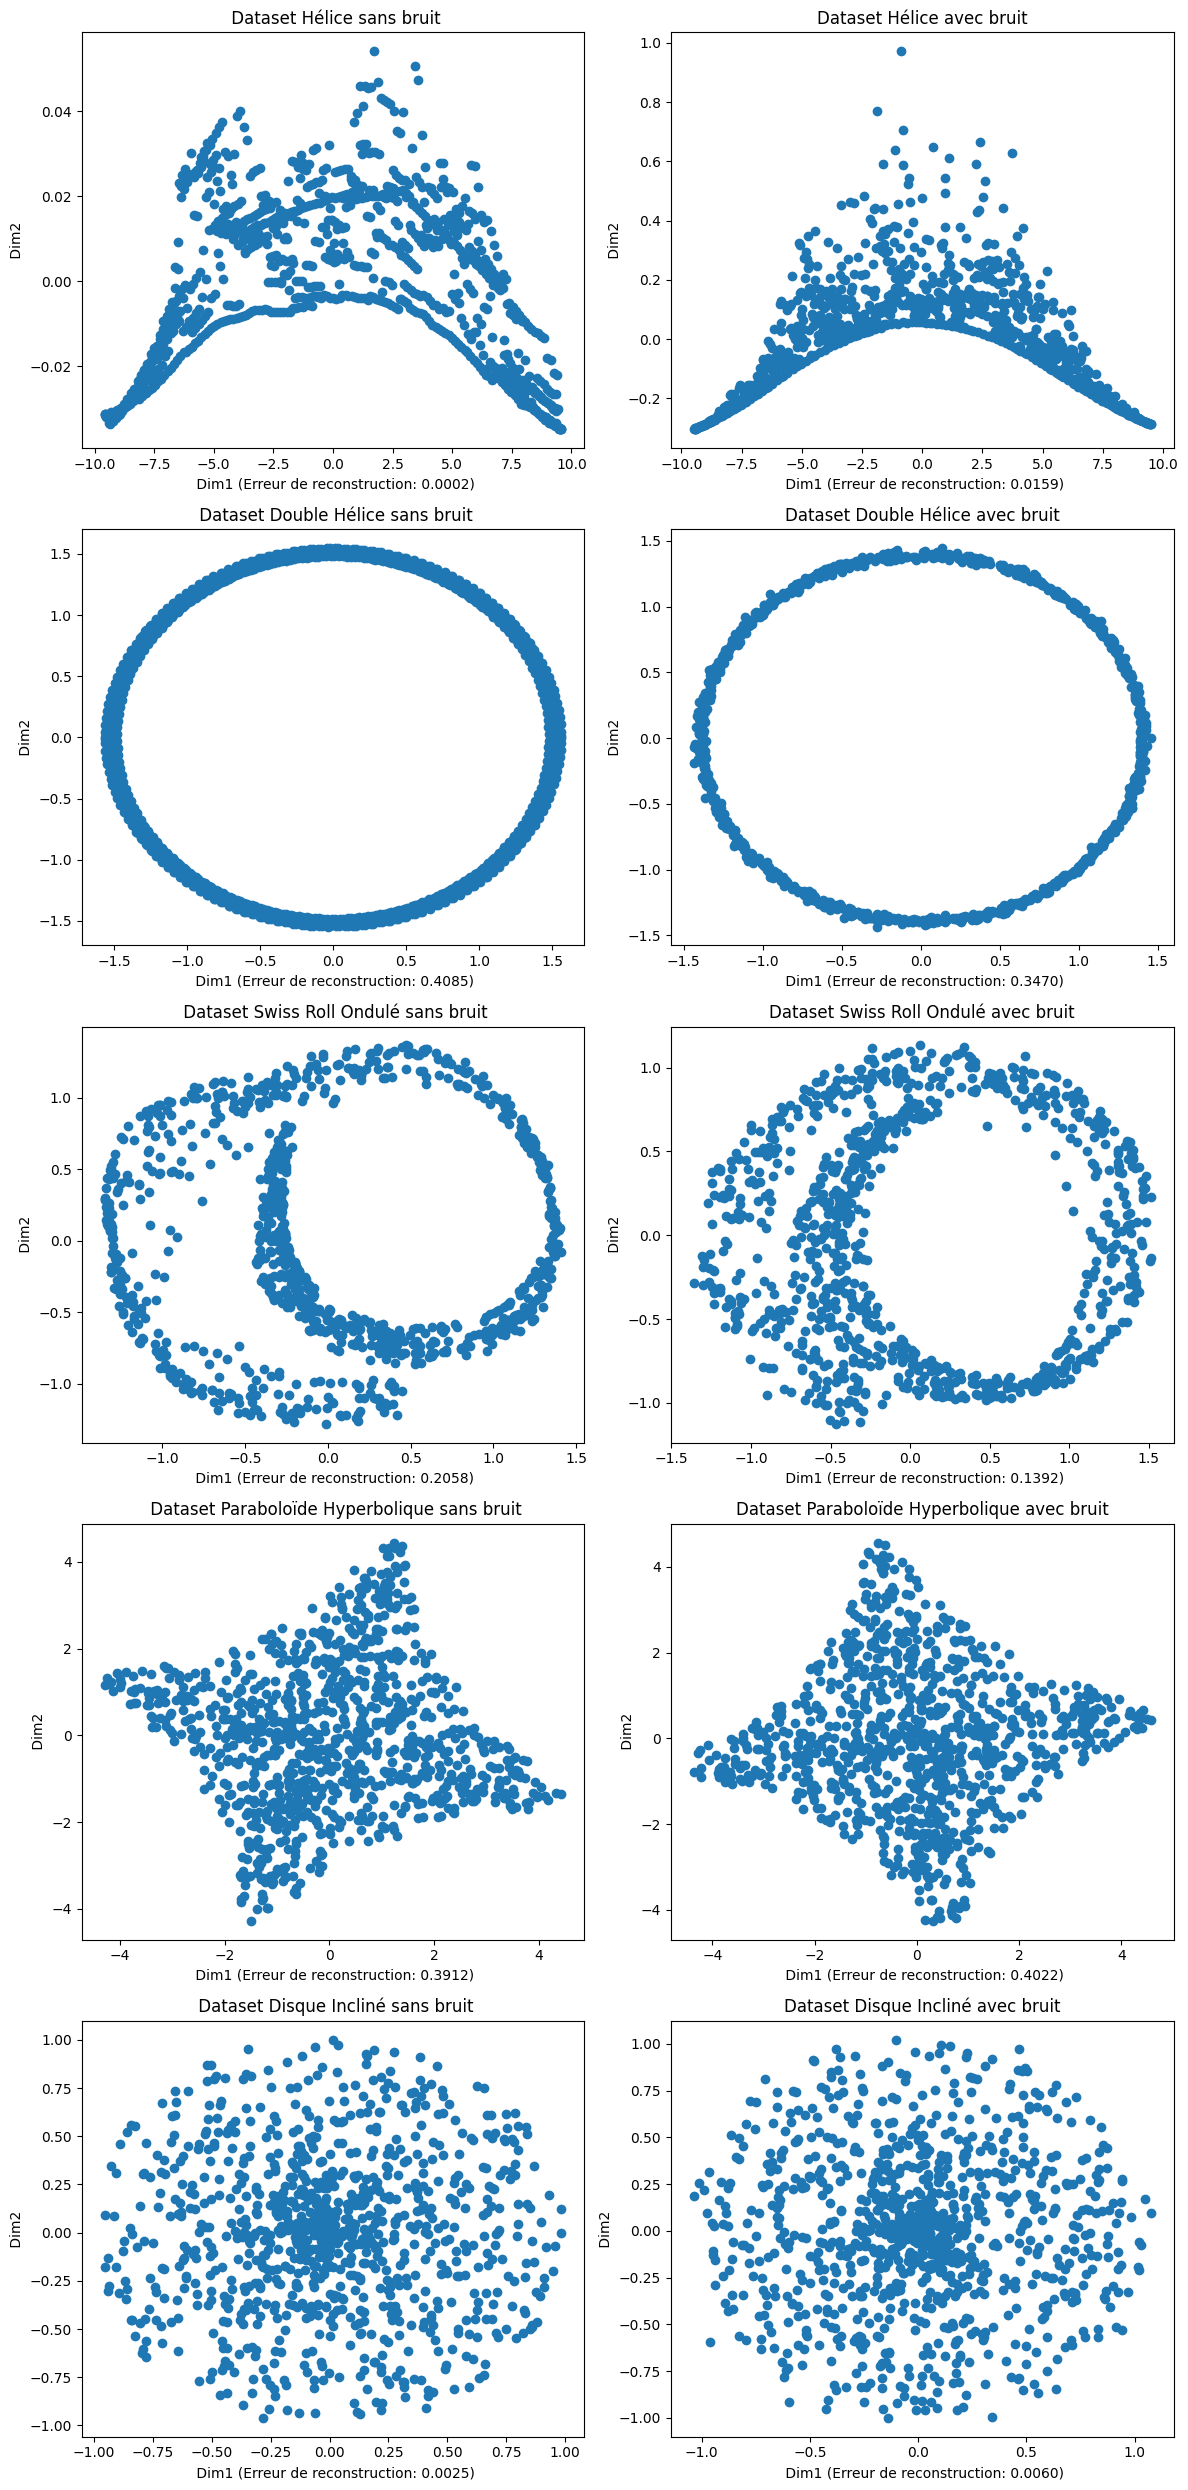

In [18]:
# Nombre de datasets
n_datasets = len(Isomap_datasets_1)

# Noms des datasets
noms = ["Hélice", "Double Hélice", "Swiss Roll Ondulé", "Paraboloïde Hyperbolique", "Disque Incliné"]

# Création de la figure avec des subplots pour chaque dataset
fig, axes = plt.subplots(n_datasets, 2, figsize=(12, 5 * n_datasets))

# Boucle pour tracer chaque dataset
for i in range(n_datasets):
    # Dataset sans bruit (Isomap_datasets_1)
    X_isomap_1 = Isomap_datasets_1[i][0]
    erreur_reconstruction_1 = Isomap_datasets_1[i][1]
    axes[i, 0].scatter(X_isomap_1[:, 0], X_isomap_1[:, 1], cmap='coolwarm')
    axes[i, 0].set_title(f" Dataset {noms[i]} sans bruit")
    axes[i, 0].set_xlabel(f" Dim1 (Erreur de reconstruction: {erreur_reconstruction_1:.4f})")
    axes[i, 0].set_ylabel(f" Dim2 ")

    # Dataset avec bruit (Isomap_datasets_2)
    X_isomap_2 = Isomap_datasets_2[i][0]
    erreur_reconstruction_2 = Isomap_datasets_2[i][1]
    axes[i, 1].scatter(X_isomap_2[:, 0], X_isomap_2[:, 1], cmap='coolwarm')
    axes[i, 1].set_title(f"Dataset {noms[i]} avec bruit")
    axes[i, 1].set_xlabel(f" Dim1 (Erreur de reconstruction: {erreur_reconstruction_2:.4f})")
    axes[i, 1].set_ylabel(f" Dim2 ")

# Ajuster les espaces entre les subplots
plt.tight_layout()
plt.show()


### 3.3 LLE (Locally Linear Embedding)



**Locally Linear Embedding (LLE)** est une méthode élégante de réduction de dimensionnalité, non linéaire, qui préserve les relations locales entre les points dans les données. Contrairement à PCA, LLE essaie de conserver la géométrie locale des points de données sur un manifold non linéaire en se basant sur les plus proches voisins.

### Étapes et fondements mathématiques de LLE

1. **Construction du graphe des voisins** :
   Pour chaque point $X_i$, trouver les $k$ plus proches voisins $X_j$.

2. **Calcul des poids de reconstruction** :
   Chaque point est représenté comme une combinaison linéaire de ses voisins. On cherche à minimiser :
   
   $\epsilon(W) = \sum_i |X_i - \sum_j W_{ij}X_j|^2$
   
   sous les contraintes $\sum_j W_{ij} = 1$ et $W_{ij} = 0$ si $X_j$ n'est pas un voisin de $X_i$.

3. **Réduction de dimensionnalité** :
   Trouver une représentation $Y$ de faible dimension qui minimise :
   
   $\Phi(Y) = \sum_i |Y_i - \sum_j W_{ij}Y_j|^2$
   
   sous les contraintes $\sum_i Y_i = 0$, $\frac{1}{N} \sum_i Y_i Y_i^T = I$.

La solution pour $Y$ est donnée par les vecteurs propres associés aux plus petites valeurs propres non nulles de la matrice $(I-W)^T(I-W)$, où $W$ est la matrice des poids.

LLE parvient ainsi à capturer la structure non linéaire des données en préservant les relations locales, ce qui le rend particulièrement adapté pour des manifolds complexes comme le Swiss Roll ou des formes en hélice.

### Calibrage

In [19]:


# Fonction pour calculer l'erreur de reconstruction basée sur l'écart local de reconstruction
def calculer_erreur_reconstruction(X_original, X_reduit):
    """
    Calcule l'erreur de reconstruction basée sur la différence entre les distances euclidiennes
    dans l'espace original et l'espace réduit.

    :param X_original: Matrice des données dans l'espace original
    :param X_reduit: Matrice des données dans l'espace réduit
    :return: Erreur de reconstruction (moyenne des différences de distances)
    """
    distances_original = pairwise_distances(X_original)
    distances_reduit = pairwise_distances(X_reduit)

    erreur_reconstruction = np.mean(np.abs(distances_original - distances_reduit))

    return erreur_reconstruction

# Fonction d'objectif pour Optuna
def objective(trial, dataset):
    # Intervalle du nombre de composantes principales (dimensions réduites)
    n_components = trial.suggest_int('n_components', 2, 10)

    # Nombre de voisins à utiliser pour la construction du graphe
    n_neighbors = trial.suggest_int('n_neighbors', 5, 30)

    # Instancier l'objet LLE avec les hyperparamètres suggérés
    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)

    # Appliquer LLE et récupérer les données projetées
    X_lle = lle.fit_transform(dataset)

    # Calculer l'erreur de reconstruction
    erreur_reconstruction = calculer_erreur_reconstruction(dataset, X_lle)

    # Minimiser l'erreur de reconstruction
    return erreur_reconstruction

# Listes pour stocker les meilleurs hyperparamètres
best_params_1 = []
best_params_2 = []

# Optimisation sur datasets_1 (sans bruit)
for dataset in datasets_1:
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur de reconstruction
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_1.append(study.best_params)

# Optimisation sur datasets_2 (avec bruit)
for dataset in datasets_2:
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur de reconstruction
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_2.append(study.best_params)

# Appliquer LLE avec les hyperparamètres optimisés et stocker les résultats
LLE_datasets_1 = []
LLE_datasets_2 = []

# Appliquer LLE sur datasets_1 (sans bruit)
for i, dataset in enumerate(datasets_1):
    n_components = best_params_1[i]['n_components']
    n_neighbors = best_params_1[i]['n_neighbors']

    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    X_lle = lle.fit_transform(dataset)
    erreur_reconstruction = calculer_erreur_reconstruction(dataset, X_lle)

    LLE_datasets_1.append((X_lle, erreur_reconstruction))

# Appliquer LLE sur datasets_2 (avec bruit)
for i, dataset in enumerate(datasets_2):
    n_components = best_params_2[i]['n_components']
    n_neighbors = best_params_2[i]['n_neighbors']

    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors)
    X_lle = lle.fit_transform(dataset)
    erreur_reconstruction = calculer_erreur_reconstruction(dataset, X_lle)

    LLE_datasets_2.append((X_lle, erreur_reconstruction))

# Affichage des résultats pour datasets_1 (sans bruit)
print("Résultats LLE pour datasets_1 (sans bruit) :")
for i, (X_lle, erreur_reconstruction) in enumerate(LLE_datasets_1):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction (basée sur les distances) : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_lle[:5]}\n")  # Afficher les 5 premières coordonnées

# Affichage des résultats pour datasets_2 (avec bruit)
print("Résultats LLE pour datasets_2 (avec bruit) :")
for i, (X_lle, erreur_reconstruction) in enumerate(LLE_datasets_2):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction (basée sur les distances) : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_lle[:5]}\n")  # Afficher les 5 premières coordonnées

# Créer un DataFrame récapitulatif des meilleurs hyperparamètres
datasets_names = [f'Dataset {i+1}' for i in range(len(datasets_1))]  # Nommer les datasets
df = pd.DataFrame({
    'Sans Bruit': best_params_1,
    'Avec Bruit': best_params_2
}, index=datasets_names)

# Afficher le DataFrame récapitulatif
display(df)

[I 2024-10-17 05:05:23,705] A new study created in memory with name: no-name-52072d7a-d229-4ae9-9461-135330b0884e
[I 2024-10-17 05:05:23,866] Trial 0 finished with value: 1.6528387850580486 and parameters: {'n_components': 5, 'n_neighbors': 15}. Best is trial 0 with value: 1.6528387850580486.
[I 2024-10-17 05:05:24,223] Trial 1 finished with value: 1.6097894171972926 and parameters: {'n_components': 10, 'n_neighbors': 20}. Best is trial 1 with value: 1.6097894171972926.
[I 2024-10-17 05:05:24,448] Trial 2 finished with value: 1.6251159477846633 and parameters: {'n_components': 8, 'n_neighbors': 5}. Best is trial 1 with value: 1.6097894171972926.
[I 2024-10-17 05:05:24,704] Trial 3 finished with value: 1.6428466706663125 and parameters: {'n_components': 6, 'n_neighbors': 25}. Best is trial 1 with value: 1.6097894171972926.
[I 2024-10-17 05:05:24,941] Trial 4 finished with value: 1.6916457600295438 and parameters: {'n_components': 2, 'n_neighbors': 9}. Best is trial 1 with value: 1.60978

Résultats LLE pour datasets_1 (sans bruit) :
Dataset 1 :
  Erreur de reconstruction (basée sur les distances) : 1.6097
  Coordonnées dans le nouvel espace :
 [[ 0.05228697  0.05699163  0.06283602 -0.05929408  0.0622941  -0.06438554
   0.0576815  -0.06124589 -0.06350729  0.06602748]
 [ 0.05221425  0.05678442  0.06243297 -0.05874659  0.06153548 -0.06340585
   0.05663118 -0.05993847 -0.06196347  0.06420759]
 [ 0.05214061  0.05657458  0.06202482 -0.05819217  0.06076725 -0.06241375
   0.05556755 -0.05861447 -0.06040006  0.06236457]
 [ 0.05206522  0.05635975  0.06160698 -0.05762459  0.05998079 -0.06139812
   0.0544787  -0.05725911 -0.05879965  0.060478  ]
 [ 0.05199065  0.05614724  0.06119364 -0.05706313  0.05920282 -0.06039345
   0.0534016  -0.05591838 -0.05721653  0.05861183]]

Dataset 2 :
  Erreur de reconstruction (basée sur les distances) : 1.2996
  Coordonnées dans le nouvel espace :
 [[ 0.05469408  0.02442172  0.04778105 -0.00505794 -0.07414554  0.05002931
  -0.02494512 -0.07619516  0

Sans Bruit  \
Dataset 1   {'n_components': 10, 'n_neighbors': 5}   
Dataset 2  {'n_components': 10, 'n_neighbors': 26}   
Dataset 3  {'n_components': 10, 'n_neighbors': 16}   
Dataset 4  {'n_components': 10, 'n_neighbors': 29}   
Dataset 5  {'n_components': 10, 'n_neighbors': 28}   

                                        Avec Bruit  
Dataset 1  {'n_components': 10, 'n_neighbors': 30}  
Dataset 2  {'n_components': 10, 'n_neighbors': 20}  
Dataset 3  {'n_components': 10, 'n_neighbors': 19}  
Dataset 4  {'n_components': 10, 'n_neighbors': 18}  
Dataset 5  {'n_components': 10, 'n_neighbors': 27}

In [20]:
# Appliquer LLE avec les hyperparamètres optimisés et stocker les résultats
LLE_datasets_1 = []
LLE_datasets_2 = []

# Appliquer LLE sur datasets_1 (sans bruit) avec les hyperparamètres optimisés
for i, dataset in enumerate(datasets_1):
    n_components = best_params_1[i]['n_components']
    n_neighbors = best_params_1[i]['n_neighbors']

    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)
    X_lle = lle.fit_transform(dataset)
    erreur_reconstruction = calculer_erreur_reconstruction(dataset, X_lle)

    LLE_datasets_1.append((X_lle, erreur_reconstruction))

# Appliquer LLE sur datasets_2 (avec bruit) avec les hyperparamètres optimisés
for i, dataset in enumerate(datasets_2):
    n_components = best_params_2[i]['n_components']
    n_neighbors = best_params_2[i]['n_neighbors']

    lle = LocallyLinearEmbedding(n_components=n_components, n_neighbors=n_neighbors, n_jobs=-1)
    X_lle = lle.fit_transform(dataset)
    erreur_reconstruction = calculer_erreur_reconstruction(dataset, X_lle)

    LLE_datasets_2.append((X_lle, erreur_reconstruction))

# Affichage des résultats pour datasets_1 (sans bruit)
print("Résultats LLE pour datasets_1 (sans bruit) :")
for i, (X_lle, erreur_reconstruction) in enumerate(LLE_datasets_1):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction (basée sur les distances) : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_lle[:5]}\n")  # Afficher les 5 premières coordonnées

# Affichage des résultats pour datasets_2 (avec bruit)
print("Résultats LLE pour datasets_2 (avec bruit) :")
for i, (X_lle, erreur_reconstruction) in enumerate(LLE_datasets_2):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction (basée sur les distances) : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_lle[:5]}\n")  # Afficher les 5 premières coordonnées


Résultats LLE pour datasets_1 (sans bruit) :
Dataset 1 :
  Erreur de reconstruction (basée sur les distances) : 1.6097
  Coordonnées dans le nouvel espace :
 [[ 0.05228697  0.05699163  0.06283602 -0.05929408  0.0622941  -0.06438554
   0.0576815  -0.06124589 -0.06350729  0.06602748]
 [ 0.05221425  0.05678442  0.06243297 -0.05874659  0.06153548 -0.06340585
   0.05663118 -0.05993847 -0.06196347  0.06420759]
 [ 0.05214061  0.05657458  0.06202482 -0.05819217  0.06076725 -0.06241375
   0.05556755 -0.05861447 -0.06040006  0.06236457]
 [ 0.05206522  0.05635975  0.06160698 -0.05762459  0.05998079 -0.06139812
   0.0544787  -0.05725911 -0.05879965  0.060478  ]
 [ 0.05199065  0.05614724  0.06119364 -0.05706313  0.05920282 -0.06039345
   0.0534016  -0.05591838 -0.05721653  0.05861183]]

Dataset 2 :
  Erreur de reconstruction (basée sur les distances) : 1.2996
  Coordonnées dans le nouvel espace :
 [[ 0.05469408  0.02442172  0.04778105 -0.00505794 -0.07414554  0.05002931
  -0.02494512 -0.07619516  0

<ipython-input-21-ebdb9ed8b7cb>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 0].scatter(X_lle_1[:, 0], X_lle_1[:, 1], cmap='coolwarm')
<ipython-input-21-ebdb9ed8b7cb>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 1].scatter(X_lle_2[:, 0], X_lle_2[:, 1], cmap='coolwarm')


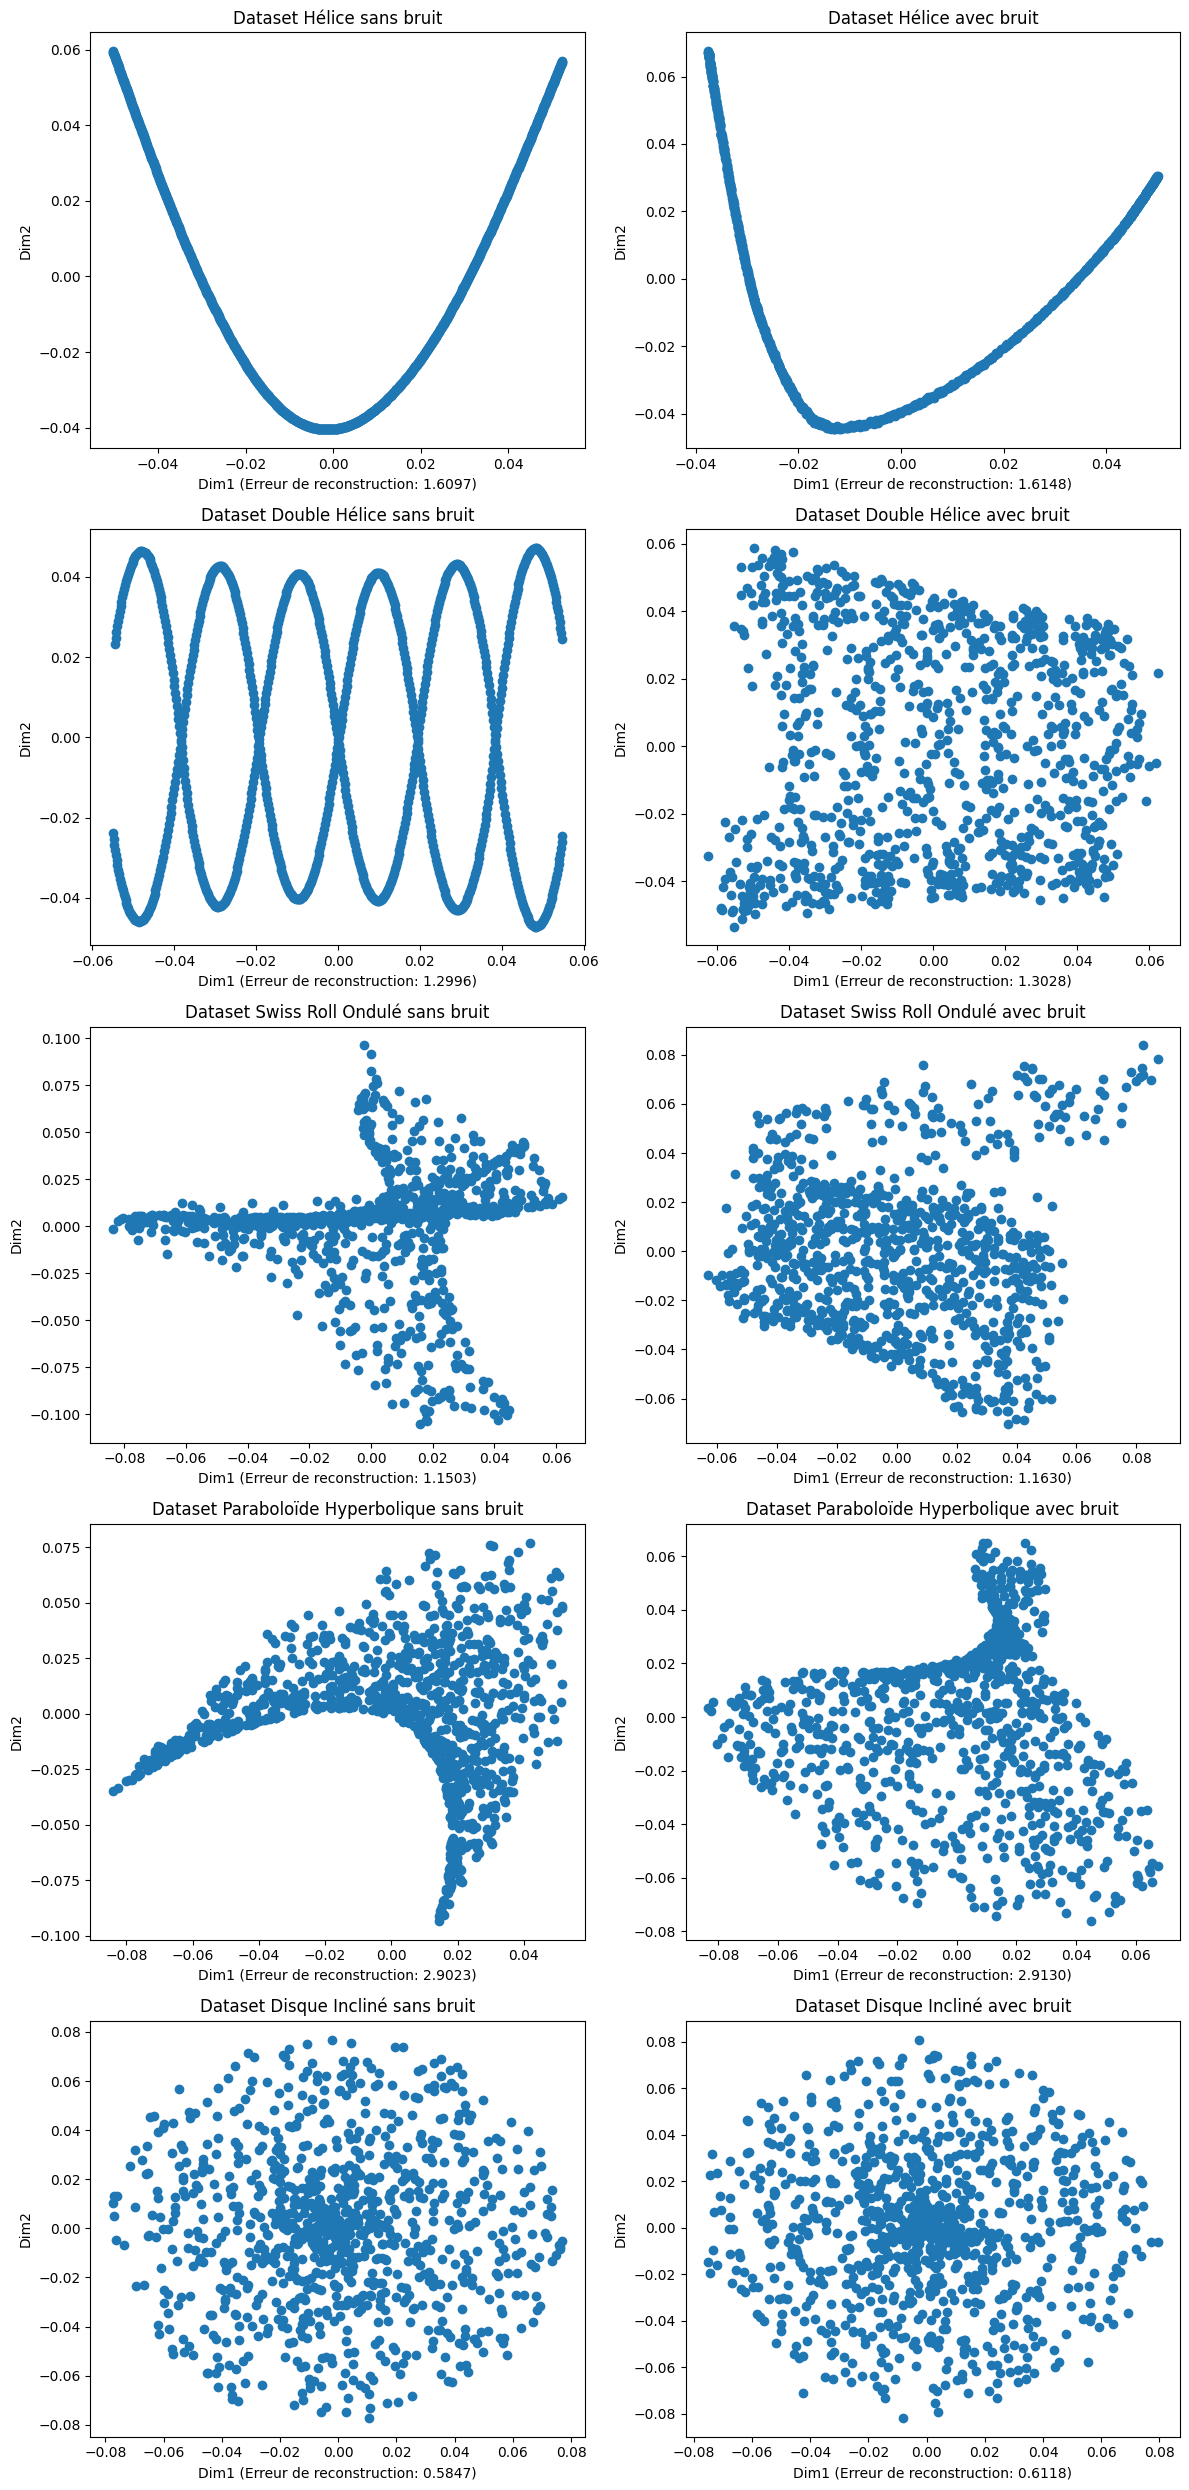

In [21]:
# Nombre de datasets
n_datasets = len(LLE_datasets_1)

# Noms des datasets
noms = ["Hélice", "Double Hélice", "Swiss Roll Ondulé", "Paraboloïde Hyperbolique", "Disque Incliné"]

# Création de la figure avec des subplots pour chaque dataset
fig, axes = plt.subplots(n_datasets, 2, figsize=(12, 5 * n_datasets))

# Boucle pour tracer chaque dataset
for i in range(n_datasets):
    # Dataset sans bruit (LLE_datasets_1)
    X_lle_1 = LLE_datasets_1[i][0]
    erreur_reconstruction_1 = LLE_datasets_1[i][1]
    axes[i, 0].scatter(X_lle_1[:, 0], X_lle_1[:, 1], cmap='coolwarm')
    axes[i, 0].set_title(f"Dataset {noms[i]} sans bruit")
    axes[i, 0].set_xlabel(f"Dim1 (Erreur de reconstruction: {erreur_reconstruction_1:.4f})")
    axes[i, 0].set_ylabel("Dim2")

    # Dataset avec bruit (LLE_datasets_2)
    X_lle_2 = LLE_datasets_2[i][0]
    erreur_reconstruction_2 = LLE_datasets_2[i][1]
    axes[i, 1].scatter(X_lle_2[:, 0], X_lle_2[:, 1], cmap='coolwarm')
    axes[i, 1].set_title(f"Dataset {noms[i]} avec bruit")
    axes[i, 1].set_xlabel(f"Dim1 (Erreur de reconstruction: {erreur_reconstruction_2:.4f})")
    axes[i, 1].set_ylabel("Dim2")

# Ajuster les espaces entre les subplots
plt.tight_layout()
plt.show()


### 3.4 Auto encoders

## Concept des Autoencodeurs

Les autoencodeurs sont des réseaux de neurones artificiels utilisés pour l'apprentissage non supervisé de représentations de données.

Un autoencodeur se compose de deux parties principales :

1. **Encodeur** : Compresse les données d'entrée en une représentation de dimension inférieure.
2. **Décodeur** : Tente de reconstruire les données originales à partir de cette représentation compressée.

## Fonctionnement

1. L'encodeur transforme les données d'entrée X en une représentation latente Z de dimension inférieure.
2. Le décodeur tente de reconstruire X' à partir de Z.
3. L'objectif est de minimiser la différence entre X et X', généralement mesurée par l'erreur quadratique moyenne.

## Avantages pour la Réduction de Dimensionnalité

1. **Non-linéarité** : Contrairement à l'ACP, les autoencodeurs peuvent capturer des relations non linéaires dans les données.
2. **Flexibilité** : La structure du réseau peut être adaptée à la complexité des données.
3. **Apprentissage de caractéristiques** : L'encodeur apprend automatiquement les caractéristiques les plus pertinentes.

## Paramètres Clés

Les principaux hyperparamètres que nous avons ajustés incluent :

- Architecture du réseau (nombre de couches, neurones par couche)
- Fonction d'activation (ReLU, tanh, sigmoid)
- Taille de la couche latente (détermine le degré de compression)


## Défis et Considérations

1. **Surapprentissage** : Risque de simplement "mémoriser" les données d'entrée sans généraliser.
2. **Choix de l'architecture** : Trouver la bonne structure peut nécessiter beaucoup d'expérimentations.
3. **Interprétabilité** : Les caractéristiques apprises peuvent être moins interprétables que celles de l'ACP.



### Calibrage

In [22]:
import optuna
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import pairwise_distances

# Fonction d'objectif pour Optuna
def objective(trial, dataset):
    # Hyperparamètres à optimiser
    n_layers = trial.suggest_int('n_layers', 2, 5)  # Nombre de couches dans l'encodeur et le décodeur
    n_neurons = trial.suggest_categorical('n_neurons', [64, 128, 256])  # Nombre de neurones par couche
    n_components = trial.suggest_int('n_components', 2, 10)  # Taille du goulot (manifold)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)  # Taux de dropout pour éviter le surapprentissage

    # Obtenir le nombre de caractéristiques
    n_features = dataset.shape[1]

    # Définir l'autoencodeur avec l'architecture optimisée par Optuna
    input_data = layers.Input(shape=(n_features,))

    # Encoder avec un nombre de couches et de neurones optimisés
    x = input_data
    for _ in range(n_layers):
        x = layers.Dense(n_neurons)(x)
        x = LeakyReLU()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout_rate)(x)

    # Goulot d'étranglement (manifold)
    encoded = layers.Dense(n_components)(x)

    # Décodeur symétrique
    for _ in range(n_layers):
        x = layers.Dense(n_neurons)(encoded)
        x = LeakyReLU()(x)
        x = layers.BatchNormalization()(x)

    # Sortie de l'autoencodeur
    decoded = layers.Dense(n_features, activation='sigmoid')(x)

    # Construire l'autoencodeur et l'encodeur
    autoencoder = models.Model(input_data, decoded)
    encoder = models.Model(input_data, encoded)

    # Compiler l'autoencodeur
    autoencoder.compile(optimizer=Adam(), loss='mse')

    # Entraîner l'autoencodeur
    history = autoencoder.fit(dataset, dataset, epochs=50, batch_size=32, shuffle=True, verbose=0)

    # Calculer l'erreur de reconstruction (moyenne de la perte MSE)
    erreur_reconstruction = history.history['loss'][-1]

    return erreur_reconstruction

# Optimisation sur datasets_1 (sans bruit)
best_params_1 = []
for dataset in datasets_1:
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur de reconstruction
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_1.append(study.best_params)

# Optimisation sur datasets_2 (avec bruit)
best_params_2 = []
for dataset in datasets_2:
    study = optuna.create_study(direction='minimize')  # Minimiser l'erreur de reconstruction
    study.optimize(lambda trial: objective(trial, dataset), n_trials=50)
    best_params_2.append(study.best_params)

# Créer des DataFrames récapitulatifs pour les meilleurs hyperparamètres
df_best_params_1 = pd.DataFrame(best_params_1)
df_best_params_2 = pd.DataFrame(best_params_2)

# Afficher les DataFrames
print("Meilleurs hyperparamètres pour datasets sans bruit :")
print(df_best_params_1)

print("\nMeilleurs hyperparamètres pour datasets avec bruit :")
print(df_best_params_2)

display(df_best_params_1)
display(df_best_params_2)

[I 2024-10-17 05:08:45,715] A new study created in memory with name: no-name-077c0db3-041b-4ea8-a169-6ef1132481d3
[I 2024-10-17 05:09:00,652] Trial 0 finished with value: 0.014267870225012302 and parameters: {'n_layers': 4, 'n_neurons': 256, 'n_components': 3, 'dropout_rate': 0.3037219884971877}. Best is trial 0 with value: 0.014267870225012302.
[I 2024-10-17 05:09:12,201] Trial 1 finished with value: 0.014342669397592545 and parameters: {'n_layers': 3, 'n_neurons': 64, 'n_components': 10, 'dropout_rate': 0.16040913854995392}. Best is trial 0 with value: 0.014267870225012302.
[I 2024-10-17 05:09:25,744] Trial 2 finished with value: 0.01465126033872366 and parameters: {'n_layers': 4, 'n_neurons': 128, 'n_components': 2, 'dropout_rate': 0.19256543460655295}. Best is trial 0 with value: 0.014267870225012302.
[I 2024-10-17 05:09:35,737] Trial 3 finished with value: 0.014590724371373653 and parameters: {'n_layers': 2, 'n_neurons': 64, 'n_components': 5, 'dropout_rate': 0.4553868269012939}. 

Meilleurs hyperparamètres pour datasets sans bruit :
   n_layers  n_neurons  n_components  dropout_rate
0         2        256            10      0.030682
1         2        256             6      0.003158
2         3        256             9      0.035127
3         2        128             4      0.000026
4         2        256             9      0.000867

Meilleurs hyperparamètres pour datasets avec bruit :
   n_layers  n_neurons  n_components  dropout_rate
0         2        256             3      0.023417
1         3        256             9      0.002283
2         4        256             6      0.000323
3         2        256             3      0.037940
4         3        256             8      0.028221


n_layers  n_neurons  n_components  dropout_rate
0         2        256            10      0.030682
1         2        256             6      0.003158
2         3        256             9      0.035127
3         2        128             4      0.000026
4         2        256             9      0.000867

n_layers  n_neurons  n_components  dropout_rate
0         2        256             3      0.023417
1         3        256             9      0.002283
2         4        256             6      0.000323
3         2        256             3      0.037940
4         3        256             8      0.028221

In [23]:
# Résultats lents à obtenir, enregistrement quand la cellule d'en haut est finie

AE_best_params_1 = df_best_params_1
AE_best_params_2 = df_best_params_2

import os
import pickle

# Créer le répertoire "best_params" s'il n'existe pas déjà
if not os.path.exists('best_params'):
    os.makedirs('best_params')

# Chemins des fichiers où les DataFrames seront sauvegardés
file_path_1 = os.path.join('best_params', 'AE_best_params_1.pkl')
file_path_2 = os.path.join('best_params', 'AE_best_params_2.pkl')

# Enregistrer les DataFrames sous forme de fichiers pickle
with open(file_path_1, 'wb') as f:
    pickle.dump(AE_best_params_1, f)

with open(file_path_2, 'wb') as f:
    pickle.dump(AE_best_params_2, f)

print(f"DataFrames sauvegardés dans le répertoire 'best_params'.")


DataFrames sauvegardés dans le répertoire 'best_params'.


In [24]:
# Import de la config issue du calibrage de l'autoencodeur ( pour ne pas rejouer la partie qui est lente)
import pickle

# Charger les DataFrames depuis les fichiers pickle
with open('best_params/AE_best_params_1.pkl', 'rb') as f:
    AE_best_params_1 = pickle.load(f)

with open('best_params/AE_best_params_2.pkl', 'rb') as f:
    AE_best_params_2 = pickle.load(f)

In [25]:
import optuna
import numpy as np
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import pairwise_distances
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout

# nombre d'epochs
epochs = 50
batch_size = 64

# Listes pour stocker les résultats pour les datasets sans et avec bruit
Autoencoder_datasets_1 = []
Autoencoder_datasets_2 = []

# Boucle sur datasets_1 (sans bruit) en utilisant les hyperparamètres chargés
for i, dataset in enumerate(datasets_1):
    # Obtenir le nombre de caractéristiques
    n_features = dataset.shape[1]

    # Charger les meilleurs hyperparamètres pour ce dataset
    best_params = AE_best_params_1.iloc[i]  # Utilisation des paramètres du DataFrame

    # Définir l'autoencodeur avec les hyperparamètres chargés
    input_data = layers.Input(shape=(n_features,))

    encoded = layers.Dense(256)(input_data)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)

    encoded = layers.Dense(128)(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = Dropout(best_params['dropout_rate'])(encoded)  # Dropout optimisé

    encoded = layers.Dense(n_components)(encoded)  # Goulot d'étranglement

    # Décodeur symétrique
    decoded = layers.Dense(128)(encoded)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)

    decoded = layers.Dense(256)(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = layers.Dense(n_features, activation='sigmoid')(decoded)  # Sortie avec Sigmoid

    # Construire l'autoencodeur et l'encodeur
    autoencoder = models.Model(input_data, decoded)
    encoder = models.Model(input_data, encoded)

    # Compiler l'autoencodeur
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entraîner l'autoencodeur
    history = autoencoder.fit(dataset, dataset, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=1)

    # Obtenir les coordonnées projetées dans l'espace réduit
    X_projected = encoder.predict(dataset)

    # Calculer l'erreur de reconstruction (dernière valeur de la loss)
    erreur_reconstruction = history.history['loss'][-1]

    # Stocker les résultats dans la liste Autoencoder_datasets_1
    Autoencoder_datasets_1.append((X_projected, erreur_reconstruction))

# Boucle sur datasets_2 (avec bruit) en utilisant les hyperparamètres chargés
for i, dataset in enumerate(datasets_2):
    n_features = dataset.shape[1]

    # Charger les meilleurs hyperparamètres pour ce dataset
    best_params = AE_best_params_2.iloc[i]  # Utilisation des paramètres du DataFrame

    # Définir un autoencodeur similaire pour les données bruitées
    input_data = layers.Input(shape=(n_features,))

    encoded = layers.Dense(256)(input_data)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)

    encoded = layers.Dense(128)(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = Dropout(best_params['dropout_rate'])(encoded)

    encoded = layers.Dense(n_components)(encoded)  # Goulot d'étranglement

    decoded = layers.Dense(128)(encoded)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)

    decoded = layers.Dense(256)(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = layers.Dense(n_features, activation='sigmoid')(decoded)

    # Construire l'autoencodeur et l'encodeur
    autoencoder = models.Model(input_data, decoded)
    encoder = models.Model(input_data, encoded)

    # Compiler l'autoencodeur
    autoencoder.compile(optimizer='adam', loss='mse')

    # Entraîner l'autoencodeur
    history = autoencoder.fit(dataset, dataset, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=0)

    # Obtenir les coordonnées projetées dans l'espace réduit
    X_projected = encoder.predict(dataset)

    # Calculer l'erreur de reconstruction
    erreur_reconstruction = history.history['loss'][-1]

    # Stocker les résultats dans la liste Autoencoder_datasets_2
    Autoencoder_datasets_2.append((X_projected, erreur_reconstruction))

# Affichage des résultats pour datasets_1 (sans bruit)
print("Résultats Autoencodeur pour datasets_1 (sans bruit) :")
for i, (X_projected, erreur_reconstruction) in enumerate(Autoencoder_datasets_1):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_projected[:5]}\n")  # Afficher les 5 premières coordonnées

# Affichage des résultats pour datasets_2 (avec bruit)
print("Résultats Autoencodeur pour datasets_2 (avec bruit) :")
for i, (X_projected, erreur_reconstruction) in enumerate(Autoencoder_datasets_2):
    print(f"Dataset {i+1} :")
    print(f"  Erreur de reconstruction : {erreur_reconstruction:.4f}")
    print(f"  Coordonnées dans le nouvel espace :\n {X_projected[:5]}\n")  # Afficher les 5 premières coordonnées

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.2220
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0340 
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0148 
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142 
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0141 
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0140 
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0139 
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 
Epoch 13/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0143 
Epoch 14/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0134 
Epoch 15/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0147 
Epo

<ipython-input-26-11299f3732da>:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 0].scatter(X_auto_1[:, 0], X_auto_1[:, 1], cmap='coolwarm')
<ipython-input-26-11299f3732da>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[i, 1].scatter(X_auto_2[:, 0], X_auto_2[:, 1], cmap='coolwarm')


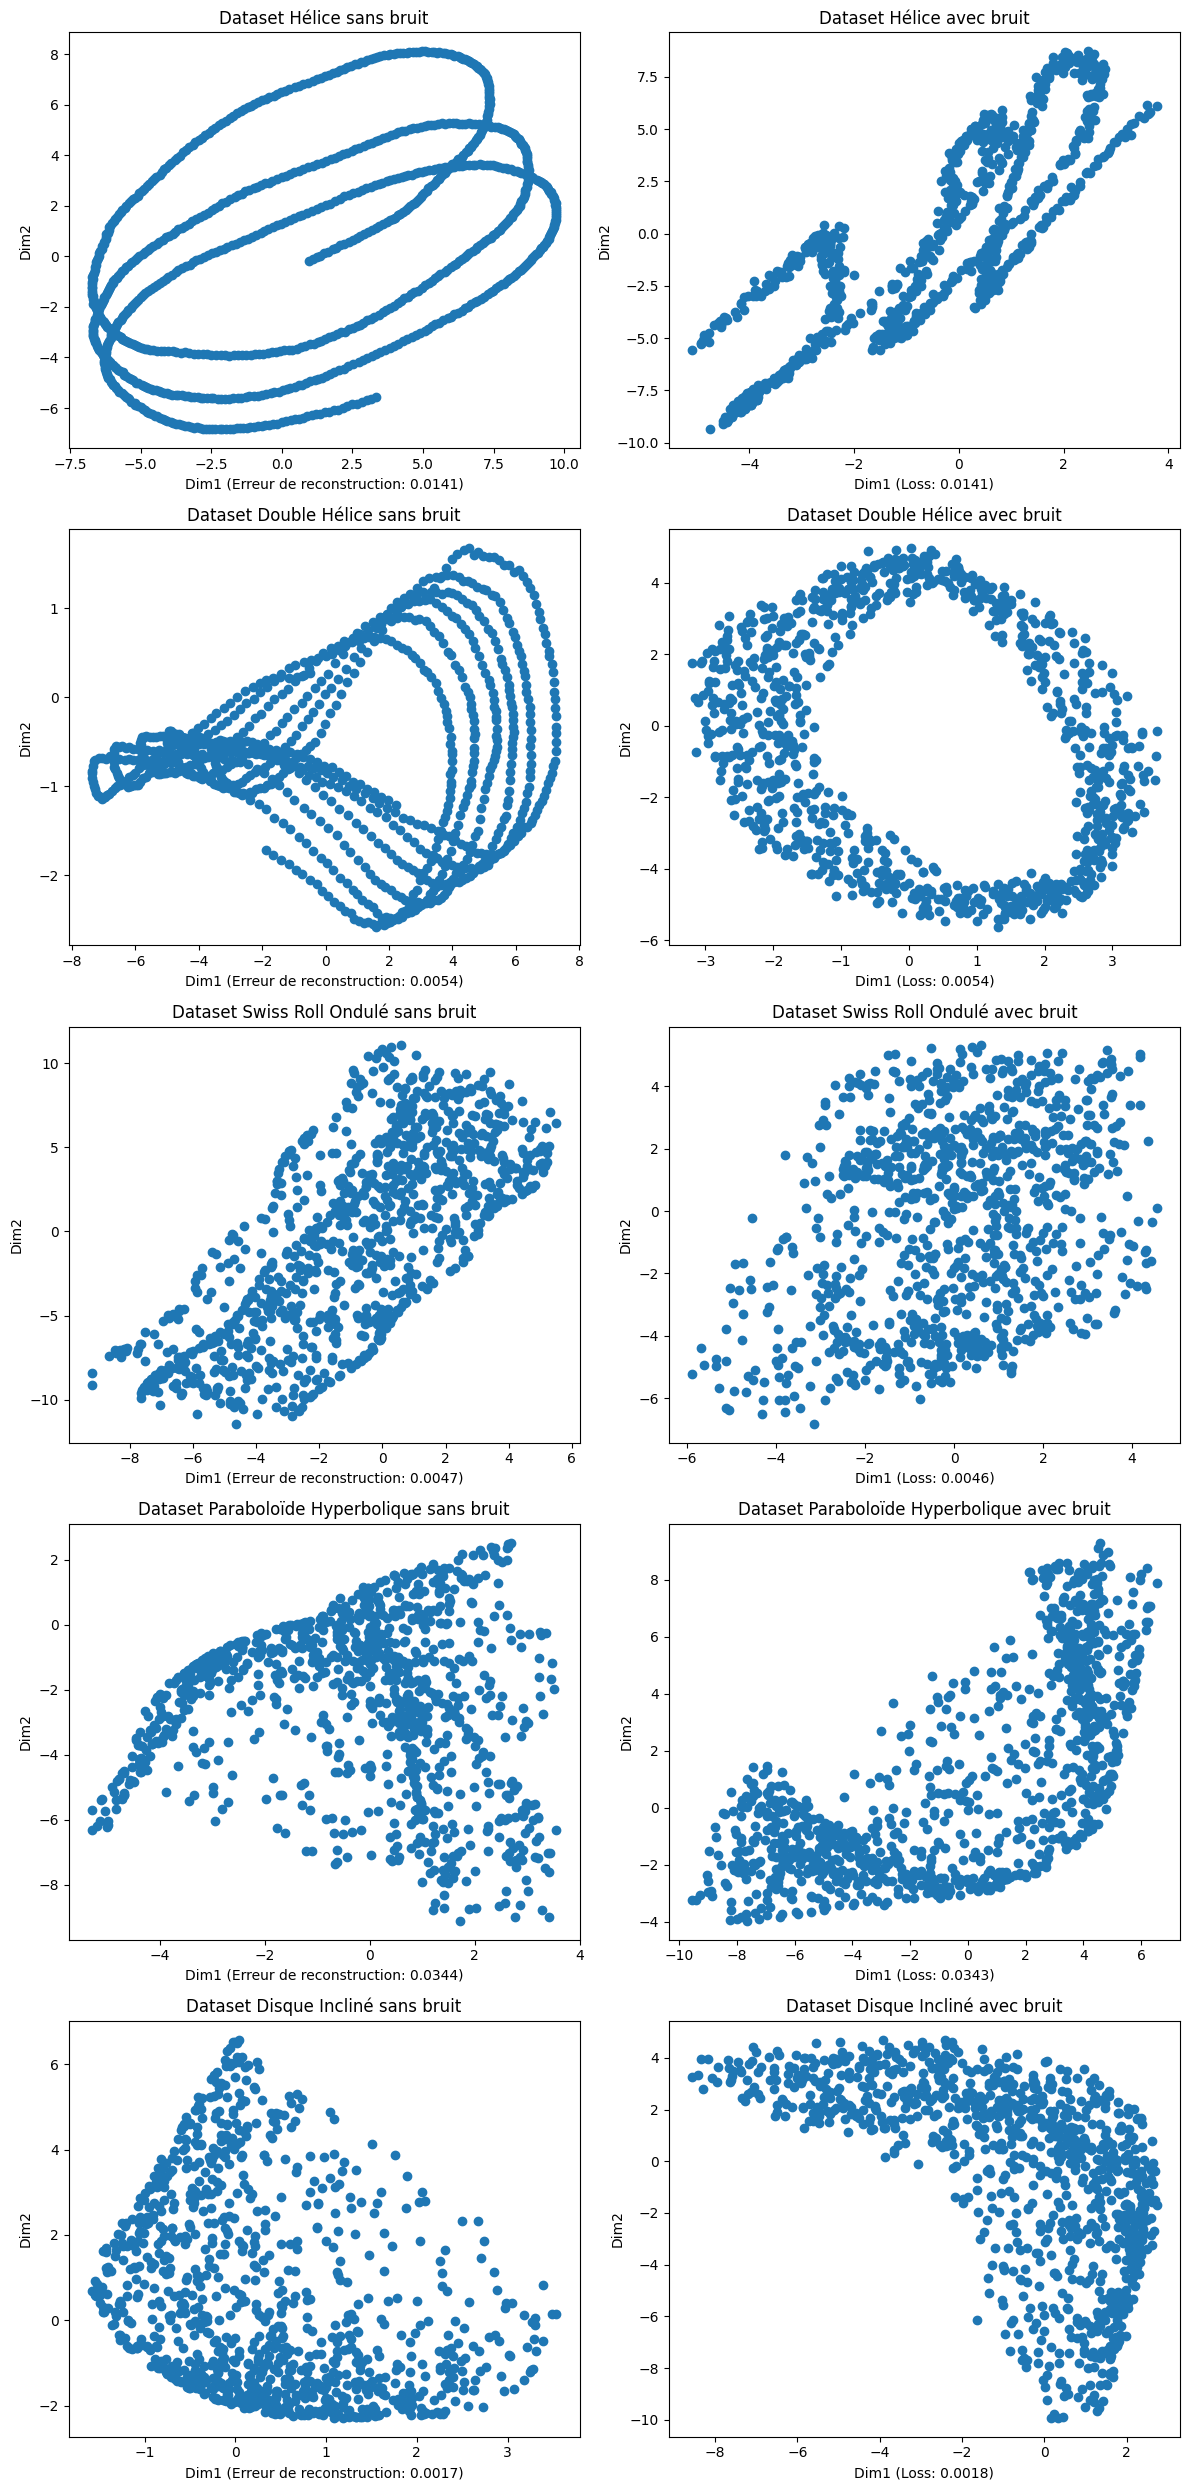

In [26]:
# Nombre de datasets
n_datasets = len(Autoencoder_datasets_1)

# Noms des datasets
noms = ["Hélice", "Double Hélice", "Swiss Roll Ondulé", "Paraboloïde Hyperbolique", "Disque Incliné"]

# Création de la figure avec des subplots pour chaque dataset
fig, axes = plt.subplots(n_datasets, 2, figsize=(12, 5 * n_datasets))

# Boucle pour tracer chaque dataset
for i in range(n_datasets):
    # Dataset sans bruit (Autoencoder_datasets_1)
    X_auto_1 = Autoencoder_datasets_1[i][0]
    erreur_reconstruction_1 = Autoencoder_datasets_1[i][1]
    axes[i, 0].scatter(X_auto_1[:, 0], X_auto_1[:, 1], cmap='coolwarm')
    axes[i, 0].set_title(f"Dataset {noms[i]} sans bruit")
    axes[i, 0].set_xlabel(f"Dim1 (Erreur de reconstruction: {erreur_reconstruction_1:.4f})")
    axes[i, 0].set_ylabel("Dim2")

    # Dataset avec bruit (Autoencoder_datasets_2)
    X_auto_2 = Autoencoder_datasets_2[i][0]
    erreur_reconstruction_2 = Autoencoder_datasets_2[i][1]
    axes[i, 1].scatter(X_auto_2[:, 0], X_auto_2[:, 1], cmap='coolwarm')
    axes[i, 1].set_title(f"Dataset {noms[i]} avec bruit")
    axes[i, 1].set_xlabel(f"Dim1 (Loss: {erreur_reconstruction_2:.4f})")
    axes[i, 1].set_ylabel("Dim2")

# Ajuster les espaces entre les subplots
plt.tight_layout()
plt.show()


#### Enregistrement de tous les résultats

In [27]:
import os
import pickle

# Créer le répertoire "results" s'il n'existe pas déjà
if not os.path.exists('results'):
    os.makedirs('results')

# Enregistrer les résultats PCA
with open('results/pca_results.pkl', 'wb') as f:
    pickle.dump(PCA_datasets_1, f)
    pickle.dump(PCA_datasets_2, f)

# Enregistrer les résultats Isomap
with open('results/isomap_results.pkl', 'wb') as f:
    pickle.dump(Isomap_datasets_1, f)
    pickle.dump(Isomap_datasets_2, f)

# Enregistrer les résultats LLE
with open('results/lle_results.pkl', 'wb') as f:
    pickle.dump(LLE_datasets_1, f)
    pickle.dump(LLE_datasets_2, f)

# Enregistrer les résultats Autoencoder
with open('results/autoencoder_results.pkl', 'wb') as f:
    pickle.dump(Autoencoder_datasets_1, f)
    pickle.dump(Autoencoder_datasets_2, f)

print("Les résultats ont été enregistrés avec succès dans le dossier 'results'.")


Les résultats ont été enregistrés avec succès dans le dossier 'results'.


In [28]:
# Les ré-importer pour travailler dessus, sans rejouer le notebook :
import os
import pickle

# Chemins vers les fichiers de résultats
pca_results_path = 'results/pca_results.pkl'
isomap_results_path = 'results/isomap_results.pkl'
lle_results_path = 'results/lle_results.pkl'
autoencoder_results_path = 'results/autoencoder_results.pkl'

# Importer les résultats PCA
if os.path.exists(pca_results_path):
    with open(pca_results_path, 'rb') as f:
        PCA_datasets_1 = pickle.load(f)
        PCA_datasets_2 = pickle.load(f)
    print("Résultats PCA importés avec succès.")
else:
    print("Fichier PCA non trouvé.")

# Importer les résultats Isomap
if os.path.exists(isomap_results_path):
    with open(isomap_results_path, 'rb') as f:
        Isomap_datasets_1 = pickle.load(f)
        Isomap_datasets_2 = pickle.load(f)
    print("Résultats Isomap importés avec succès.")
else:
    print("Fichier Isomap non trouvé.")

# Importer les résultats LLE
if os.path.exists(lle_results_path):
    with open(lle_results_path, 'rb') as f:
        LLE_datasets_1 = pickle.load(f)
        LLE_datasets_2 = pickle.load(f)
    print("Résultats LLE importés avec succès.")
else:
    print("Fichier LLE non trouvé.")

# Importer les résultats Autoencodeur
if os.path.exists(autoencoder_results_path):
    with open(autoencoder_results_path, 'rb') as f:
        Autoencoder_datasets_1 = pickle.load(f)
        Autoencoder_datasets_2 = pickle.load(f)
    print("Résultats Autoencodeur importés avec succès.")
else:
    print("Fichier Autoencodeur non trouvé.")


Résultats PCA importés avec succès.
Résultats Isomap importés avec succès.
Résultats LLE importés avec succès.
Résultats Autoencodeur importés avec succès.
